In [1]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import geopandas as gpd
pd.set_option('display.max_columns', None)

## <span style="color:  #2980b9 ">**1. Préparation des DataFrames**</span>

### <span style="color:  #34495e   ; margin-left: 40px;">**1.1. Process sur dataframe mobilisation**</span>

<img src = './code snap/concat.png' />
<img src = './code snap/tocsv.png' / >

### <span style="color:  #34495e   ; margin-left: 40px;">**1.2. Chargement des Dataset**</span>

In [30]:
incident = pd.read_csv("Data csv/LFB Incident data from 2009 - 2017.csv", dtype={"IncidentNumber": str})
mobilisation = pd.read_csv("Data csv/mobilisation_2009_2017.csv", dtype={"IncidentNumber": str}, low_memory=False)

### <span style="color: #34495e ; margin-left: 40px;">**1.3. Gérer les NaN values**</span>

In [3]:
# Supprimer les lignes avec NaN values pour les 2 variables temporelles et une catégorielle qui représentent 
# 1.67 % pour Turnout et Travel  et 0.03 % pour DeployedFromLocation

mobilisation = mobilisation.dropna(subset=["TurnoutTimeSeconds", "TravelTimeSeconds", "DeployedFromLocation"]) # 22729 lignes removed

# Remplacer les NaN values

tab_nonan = incident.loc[incident['SecondPumpArriving_AttendanceTime'].notna()]
mean_secondepump = tab_nonan.SecondPumpArriving_AttendanceTime.mean()
incident["SecondPumpArriving_AttendanceTime"] = incident['SecondPumpArriving_AttendanceTime'].fillna(mean_secondepump)

incident['SpecialServiceType'] = incident['SpecialServiceType'].fillna('No Service')
incident['Easting_m'] = incident['Easting_m'].fillna(incident['Easting_rounded'])
incident['Northing_m'] = incident['Northing_m'].fillna(incident['Northing_rounded'])
incident['NumCalls'] = incident.NumCalls.fillna(1.0)

incident['SecondPumpArriving_DeployedFromStation'] = incident.loc[:,"SecondPumpArriving_DeployedFromStation"].fillna('Unknown')
mobilisation['DelayCode_Description'] = mobilisation.loc[:, "DelayCode_Description"].fillna('Unknow')
mobilisation['DateAndTimeReturned'] = mobilisation.loc[:,'DateAndTimeReturned'].fillna(0)



In [4]:
# Création d'un dictionnaire pour gérer le NaN values de FirstPumpArriving_AttendanceTime

moyen = {}
for i in incident['IncidentStationGround'].unique():
    col = incident.loc[incident["IncidentStationGround"] == i]
    moyen[i] = round(col['FirstPumpArriving_AttendanceTime'].mean(),2)

incident['mean_firstPump_arriving'] = incident['IncidentStationGround'].apply(lambda x: moyen[x])

# Remplacer les NaN values de FirstPumpArriving_AttendanceTime par les moyennes par station

incident["FirstPumpArriving_AttendanceTime"] = incident['FirstPumpArriving_AttendanceTime'].fillna(incident['mean_firstPump_arriving'])

In [5]:
# Convertion des Easting et Northing en Latitude et Longitude pour remplacer les NaN Values

from convertbng.util import convert_lonlat

east = incident['Easting_m']
nort = incident['Northing_m']
res = convert_lonlat(east, nort)

incident['lon'] = res[0]
incident['lat'] = res[1]

incident['Latitude'] = incident['Latitude'].fillna(incident['lat'])
incident['Longitude'] = incident['Longitude'].fillna(incident['lon'])

incident = incident.drop(columns=["Latitude", "Longitude"])

In [6]:
# Nettoyage de la variable IncidentNumber une des clefs primaires

incident['IncidentNumber'] = incident.IncidentNumber.str.replace(".00", "")

incident['StopCodeDescription'] = incident['StopCodeDescription'].replace('AFA', 'Atomatic False Alarm')
incident = incident.rename(columns={"IncGeo_BoroughCode":'GSS_CODE'})

### <span style="color: #34495e ; margin-left: 40px;">**1.4. Merge incident et mobilisation**</span>

In [36]:
lfb = pd.merge(incident, mobilisation, on= ['IncidentNumber', 'CalYear', 'HourOfCall'])

In [8]:
# Extraire un nouveau csv
lfb.to_csv('LFB_Incident_Mobilisation_2009_2017.csv', index=False)

### <span style="color: #34495e ; margin-left: 40px;">**1.5. Importation DataFrame et Conversion des variables**</span>

In [37]:
lfb = pd.read_csv('Data csv/LFB_Incident_Mobilisation_2009_2017.csv', dtype= {"IncidentNumber":str, 'CalYear': 'int16', 'HourOfCall': 'int16',
                                                                    "ResourceMobilisationId": 'int32', 'Resource_Code' : 'category', "PerformanceReporting": 'category',
                                                                    'TurnoutTimeSeconds': 'float32', 'TravelTimeSeconds': 'float32', 'AttendanceTimeSeconds': 'int16', 
                                                                    "DeployedFromLocation": 'category','IncidentGroup': 'category', "StopCodeDescription": 'category',
                                                                    'SpecialServiceType': 'category', "PumpCount" : 'int16', "Notional Cost (£)": 'int16', "Easting_m": 'float32', 
                                                                    "Northing_m": "float32","PumpMinutesRounded": 'int8', "Easting_rounded": 'float32', 
                                                                    "Northing_rounded": 'float32', 'PropertyCategory': 'category'}, low_memory=False)

## <span style="color:  #2980b9 ">**2. Feature Engineering**</span>

### <span style="color: #34495e ; margin-left: 40px;">**2.1. Tri des variables**</span>

In [38]:
lfb = lfb.drop(columns=["IncidentNumber", "TimeOfCall", "Postcode_full", "Postcode_district","UPRN", "USRN", "FRS", "ResourceMobilisationId",
                  "DeployedFromStation_Code", "Resource_Code", "PlusCode_Code", "PlusCode_Description", 'DelayCodeId', "Easting_m", "Northing_m",
                  "Easting_rounded", "Northing_rounded", "DateAndTimeReturned"], axis=1)

### <span style="color: #34495e ; margin-left: 40px;">**2.2. Ajout de Variable exterieur**</span>

In [39]:
# Population par Borough

pop = pd.read_excel('Data csv/boroughtpop.xlsx').drop(columns="Unnamed: 9",axis=1).drop(index=[0,34,35,37,36,38], axis=0)
dic_population = {n:i for n,i in zip(pop["Code"], pop["Census population (2011)"])}
lfb['population'] = lfb['GSS_CODE'].map(dic_population)
lfb['label_pop'] = pd.qcut(lfb['population'], q=[0, 0.25,0.75, 1], labels=['Faible densité', 'Dense', 'Très dense'])

In [40]:
# Prix médian des maisons par borough

house = pd.read_excel("Data csv/house_london.xlsx").rename(columns={"Unnamed: 0": 'name'}).drop([33,34], axis=0)

# Corriger les erreurs de nom

correction = {"City Of london": "City of London", "Kensington And chelsea": "Kensington and Chelsea",
        "Richmond Upon thames": "Kingston upon Thames", "Barking And dagenham": "Barking and Dagenham",
        "Hammersmith And fulham": "Hammersmith and Fulham", "Kingston Upon thames": "Kingston upon Thames"}
lfb['ProperCase'] = lfb['ProperCase'].replace(correction)
lfb = lfb.rename(columns={"ProperCase":"Borough"})

# Création de la colonne 

price_house = {n:i for n,i in zip(house['name'], house["Median house price"])}
lfb['price_house_median'] = lfb['Borough'].map(price_house)
lfb["label_price"]= pd.qcut(lfb['price_house_median'], q=[0, 0.25, 0.75, 1], labels=['low_cost', 'median', 'high_cost'])

### <span style="color: #34495e ; margin-left: 40px;">**2.3. Variable Temporelle**</span>

In [41]:
# Covertion des variables en temporelle

lfb.DateAndTimeLeft = pd.to_datetime(lfb['DateAndTimeLeft'])
lfb.DateAndTimeArrived = pd.to_datetime(lfb['DateAndTimeArrived'])
lfb.DateAndTimeMobilised = pd.to_datetime(lfb['DateAndTimeMobilised'])

# Labelisation en jour de la semaine et mois

lfb['Month'] = lfb['DateAndTimeMobilised'].dt.month
lfb['Name_Month'] = lfb['DateAndTimeMobilised'].dt.month_name()
lfb['Day'] = lfb['DateAndTimeMobilised'].dt.dayofweek

In [42]:
# Temps entre l'alarme et l'arrivée sur site

lfb['response_time'] = (lfb['DateAndTimeArrived'] - lfb['DateAndTimeMobilised']).dt.total_seconds()

# Durée de l'intervention

lfb['Temps_Intervention'] = (lfb['DateAndTimeLeft'] - lfb['DateAndTimeArrived']).dt.total_seconds()
lfb['Temps_Intervention'] = round(lfb['Temps_Intervention'],2)

# Durée entre l'alarme et le temps de préparer le materiel sur site avant intervenir

lfb["Total_Time"] = lfb['TurnoutTimeSeconds'] + lfb['TravelTimeSeconds'] + lfb['AttendanceTimeSeconds']

# Durée de l'intervention

lfb['Duree_intervention'] = (lfb['DateAndTimeLeft'] - lfb['DateAndTimeArrived']).dt.total_seconds()

# Durée total de mobilisation 

lfb['Total'] = lfb.Total_Time + lfb.Duree_intervention

In [43]:
# Moyenne de temps de mobilisation par station

m = lfb.groupby("IncidentStationGround").agg({"Total_Time": "mean"})
mean_per_station = {n: np.round(float(i),2) for n,i in zip(m.index, m.values)}
lfb['mean_per_station'] = lfb.IncidentStationGround.map(mean_per_station)



C:\Users\cleme\AppData\Local\Temp\ipykernel_4300\3833572162.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mean_per_station = {n: np.round(float(i),2) for n,i in zip(m.index, m.values)}


### <span style="color: #34495e ; margin-left: 40px;">**2.4. Labelisation des Variables Temporelles**</span>

In [44]:
# Création catégorie par moment de la journée

lfb["Label_journee"] = pd.cut(lfb['HourOfCall'], bins=[0, 7, 12, 14, 19, 23],
       labels=['Nuit','Matin', 'Midi', 'Après-midi', 'Soir'],right=True, include_lowest=True)
lfb['day_name'] = pd.to_datetime(lfb["DateAndTimeMobilised"]).dt.day_name()

# Durée de l'intervention

lfb['Duree_inter_label'] = pd.qcut(lfb['Duree_intervention'], q=[0, 0.25, 0.75, 1], labels=['courte', 'moyenne', 'longue'])


# Total de mobilisation

lfb['total_label'] = pd.qcut(lfb['Total'], q=[0, 0.25, 0.75, 1], labels=['rapide', 'normale', "longue"])

# Par moyenne de station

lfb['Label_mean_mob'] = pd.qcut(lfb["mean_per_station"], q=[0, 0.25, 0.75, 1], labels=["fast_mob", "mean_mob", "low_mob"])

# label de la variable response time

lfb['Label_response'] = pd.qcut(lfb["response_time"], q=[0, 0.25, 0.75, 1], labels=["fast_time", "mean_time", "low_time"])



In [45]:
lfb = lfb.drop(columns=["IncGeo_BoroughName", "IncGeo_WardName"], axis=1)

### <span style="color: #34495e ; margin-left: 40px;">**2.5. calcul de distance**</span>

In [46]:

import re

with open("Data csv/scrap.txt", "r", encoding="utf-8") as file:
    data = file.read()


stations = ['Battersea', 'Edmonton', 'Hillingdon', 'Holloway', 'Kentish Town', 'Lee Green', 'Heston', 'Shoreditch', 'Soho', 'Dowgate', 'Mitcham', 'North Kensington', 'Plumstead', \
    'Euston', 'East Ham', 'Brixton', 'Hainault', 'West Norwood', 'Walthamstow', 'Greenwich', 'Twickenham', 'Finchley', 'Deptford', 'Hornsey', 'Bexley', \
        'Willesden', 'Eltham', 'Stratford', 'Bethnal Green', 'Beckenham', 'Barnet', 'Ilford', 'East Greenwich', 'Paddington', 'Hayes', 'Wembley', \
            'Stoke Newington', 'Richmond', 'Woodside', 'Tottenham', 'Hammersmith', 'Barking', 'Enfield', 'Erith', 'Plaistow', 'New Cross', \
                'Harold Hill', 'Ruislip', 'Ealing', 'Mill Hill', 'Heathrow', 'Woodford', 'Surbiton', 'Leyton', 'Old Kent Road', 'Dagenham', \
                    'Purley', 'Kensington', 'Peckham', 'Southall', 'Dockhead', 'Lambeth', 'Poplar', 'Feltham', 'Bromley', 'Romford', 'Orpington', 'Wandsworth', 'Southgate', 'Leytonstone', 'Forest Hill', \
                        'Whitechapel', 'Croydon', 'West Hampstead', 'Harrow', 'Hornchurch', 'Stanmore', 'Fulham', 'Northolt', 'Sutton',\
                            'Acton', 'Park Royal', 'Homerton', 'Clapham', 'Islington', 'Lewisham', 'Hendon', 'New Malden', 'Chingford', 'Wennington', \
                                'Sidcup', 'Shadwell', 'Chelsea', 'Chiswick', 'Tooting', 'Wallington', 'Norbury', 'Wimbledon', 'Kingston', 'Biggin Hill', 'Addington', 'Millwall']


stations_data = []


for station in stations:
    regex = r'"{} \(\d+\).*?\[(\-?\d+\.\d+),(\-?\d+\.\d+)\]'.format(station)
    match = re.search(regex, data)
    if match:
        name = station
        latitude = float(match.group(1))
        longitude = float(match.group(2))
        stations_data.append([name, latitude, longitude])
    else:
        print("not found{} .".format(station))


df = pd.DataFrame(stations_data, columns=['IncidentStationGround', 'Latitude', 'Longitude'])


In [47]:
lfb = pd.merge(lfb, df, on= 'IncidentStationGround')

In [48]:
import math

def haversine(lon1, lat1, lon2, lat2):
    # Rayon moyen de la Terre en kilomètres
    R = 6371.0
    
    # Conversion des coordonnées en radians
    lon1_rad = math.radians(lon1)
    lat1_rad = math.radians(lat1)
    lon2_rad = math.radians(lon2)
    lat2_rad = math.radians(lat2)
    
    # Différences de latitude et de longitude
    dlon = lon2_rad - lon1_rad
    dlat = lat2_rad - lat1_rad
    
    # Calcul de la distance haversine
    a = math.sin(dlat / 2)**2 + math.cos(lat1_rad) * math.cos(lat2_rad) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distance = R * c
    
    return distance

In [49]:
lfb['Distance'] = lfb.apply(lambda row: haversine(row['lon'], row['lat'], row['Longitude'], row['Latitude']), axis=1)

In [50]:
for i in lfb.columns:
    n = lfb[i].isna().sum() *100 / len(lfb)
    if n > 0:
        print(i, " ", np.round(n,2))
print(lfb.shape)

FirstPumpArriving_DeployedFromStation   0.0
DateAndTimeLeft   3.22
DeployedFromStation_Name   0.0
Temps_Intervention   3.22
Duree_intervention   3.22
Total   3.22
Duree_inter_label   3.22
total_label   3.22
(1300601, 61)


In [51]:
lfb = lfb.dropna()

In [52]:
lfb.to_csv('Data csv/LFB_clean.csv', index=False)

## <span style="color: #2980b9  ">**3. Data Viz** </span>

### <span style="color: #34495e ; margin-left: 40px;">**3.1. Distribution**</span>

##### <span style="color: #d7dbdd  ; margin-left: 40px;">**3.1.1. Distribution temporelle**</span>

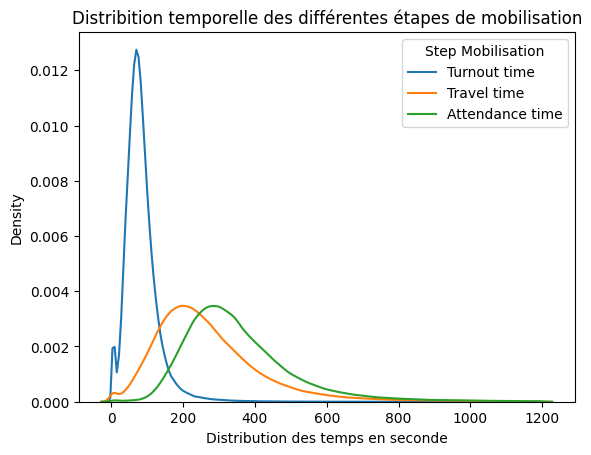

In [20]:
sns.color_palette(palette='YlGnBu')

sns.kdeplot(lfb["TurnoutTimeSeconds"], label= 'Turnout time')
sns.kdeplot(lfb['TravelTimeSeconds'], label= 'Travel time')
sns.kdeplot(lfb["AttendanceTimeSeconds"], label = 'Attendance time')
plt.xlabel("Distribution des temps en seconde")
plt.legend(title= 'Step Mobilisation')
plt.title('Distribition temporelle des différentes étapes de mobilisation')
plt.show;

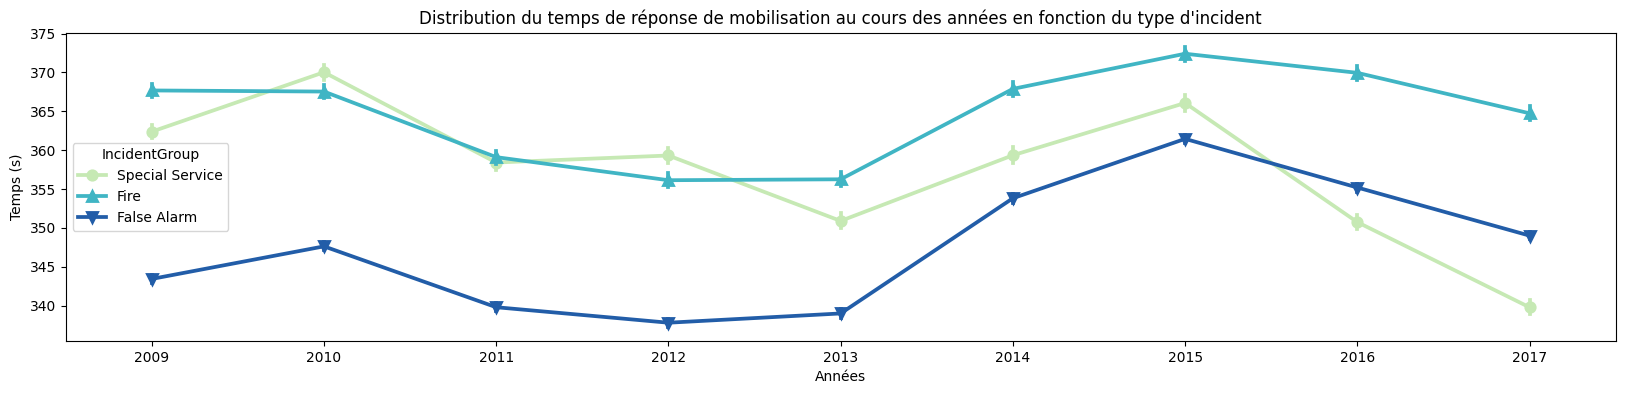

In [21]:
plt.figure(figsize=(20,4))
sns.pointplot(data=lfb, x= 'CalYear', y= "response_time", hue='IncidentGroup', errorbar= "se", marker= ["o", "^", "v"], palette='YlGnBu')
plt.xlabel('Années')
plt.ylabel('Temps (s)')
plt.title('Distribution du temps de réponse de mobilisation au cours des années en fonction du type d\'incident')
plt.show()

### <span style="color: #34495e ; margin-left: 40px;">**3.2. Incident de type service**</span>

##### <span style="color: #d7dbdd  ; margin-left: 40px;">**3.2.1. Distribution type d'incident: Feu**</span>

In [22]:

# Création d'un dictionnaire sur les nombres d'interventions en fonction du type code pour les alertes au feu
fire = lfb.loc[(lfb['IncidentGroup'] == 'Fire') & lfb['StopCodeDescription'].isin(['Chimney Fire', 'Late Call', 'Primary Fire', 'Secondary Fire'])]
data_fire = {fire['StopCodeDescription'].value_counts(normalize=True).index[n] : i 
             for n, i in enumerate(fire['StopCodeDescription'].value_counts(normalize=True))
             if i > 0}

# Création d'un dictionnaire sur les nombres d'interventions en fonction du type code pour les fausses alarmes
false_alarm = lfb.loc[(lfb['IncidentGroup'] == 'False Alarm') & lfb['StopCodeDescription'].isin(['Atomatic False Alarm','False alarm - Good intent', "False alarm - Malicious"])]
data_fasle = {false_alarm['StopCodeDescription'].value_counts(normalize=True).index[n]: i
              for n,i in enumerate(false_alarm['StopCodeDescription'].value_counts(normalize=True))
              if i > 0}


# Création des dataframes
bar_fire = pd.DataFrame(list(data_fire.items()), columns=['StopCodeDescription', 'Percentage'])
bar_false_alarm = pd.DataFrame(list(data_fasle.items()), columns=['StopCodeDescription', 'Percentage'])


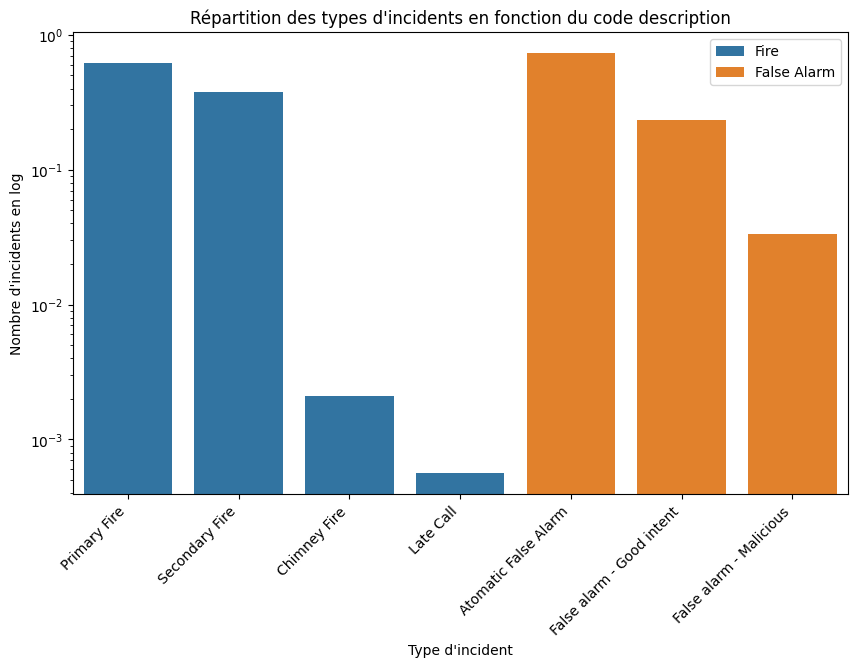

In [23]:
plt.figure(figsize=(10, 6))
incident_type_counts = lfb["IncidentGroup"].value_counts()

sns.barplot(data= bar_fire , x = "StopCodeDescription", y= 'Percentage', label= 'Fire')
sns.barplot(data= bar_false_alarm, x= "StopCodeDescription", y= 'Percentage', label = 'False Alarm')
plt.yscale('log')
plt.title("Répartition des types d'incidents en fonction du code description")
plt.xlabel("Type d'incident")
plt.ylabel("Nombre d'incidents en log")
plt.xticks(rotation=45, ha="right")
plt.legend()
plt.show()

##### <span style="color: #d7dbdd  ; margin-left: 40px;">**3.2.1. Distribution type d'incident: Service**</span>

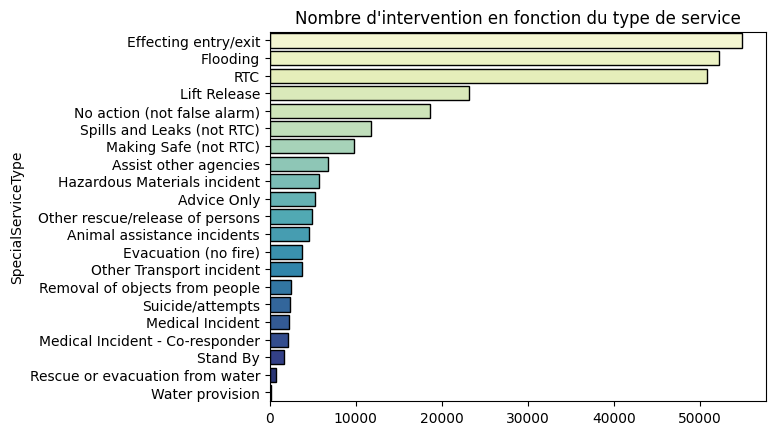

In [24]:
type_service = lfb.loc[lfb['SpecialServiceType']!= 'No Service']
bar = type_service['SpecialServiceType'].value_counts()
sns.barplot(x = bar.values , y= bar.index, hue=bar.index,palette='YlGnBu', edgecolor = 'black')
plt.title('Nombre d\'intervention en fonction du type de service')

plt.show()

### <span style="color: #34495e ; margin-left: 40px;">**3.3. Heure et type d'incident**</span>

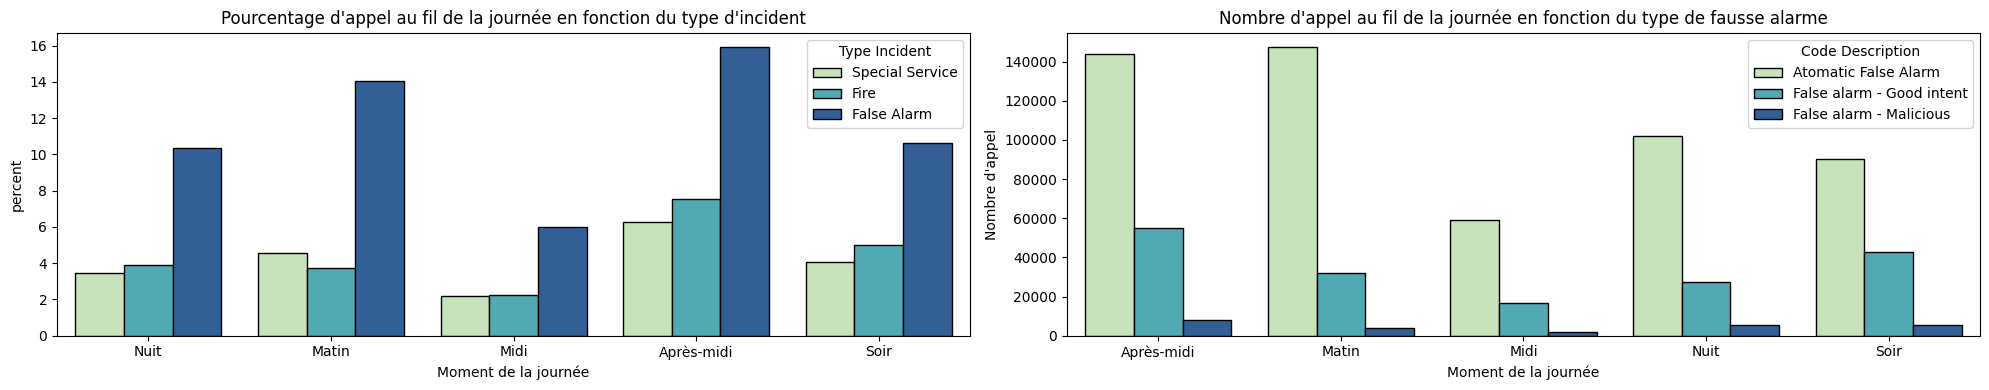

In [25]:
# Grouper par type d'incident, nature de l'incident et moment de la journée puis compter le nombre d'appel
graph_false_alarm = lfb.groupby(['IncidentGroup','StopCodeDescription', 'Label_journee'], observed=False).agg({'HourOfCall': 'count'})

# supprimer l'index car Multi-index
graph_false_alarm = graph_false_alarm.reset_index()

# changer le type de variable pour obtenir le hue 
d = {'IncidentGroup': 'str', 'StopCodeDescription': 'str', 'Label_journee': 'str'}
graph_false_alarm = graph_false_alarm.astype(d)

# Supprimer les valeurs qui ne sont pas utile

cate = ['Atomatic False Alarm', 'False alarm - Good intent', 'False alarm - Malicious']
graph_false_alarm = graph_false_alarm.query("(IncidentGroup == 'False Alarm') & (StopCodeDescription in @cate)")

# Tracé le graphique en barre

plt.figure(figsize= (20, 4))

plt.subplot(121)

sns.countplot(data= lfb, x = 'Label_journee', hue='IncidentGroup', edgecolor = 'black', stat= 'percent', palette='YlGnBu')
plt.xlabel('Moment de la journée')
plt.legend(title='Type Incident')
plt.title("Pourcentage d'appel au fil de la journée en fonction du type d'incident")


plt.subplot(122)
sns.barplot(data=graph_false_alarm, x='Label_journee', y='HourOfCall', hue='StopCodeDescription', palette='YlGnBu', edgecolor='black')
plt.xlabel('Moment de la journée')
plt.ylabel("Nombre d'appel")
plt.legend(title="Code Description")
plt.title("Nombre d'appel au fil de la journée en fonction du type de fausse alarme")
plt.tight_layout()
plt.show()

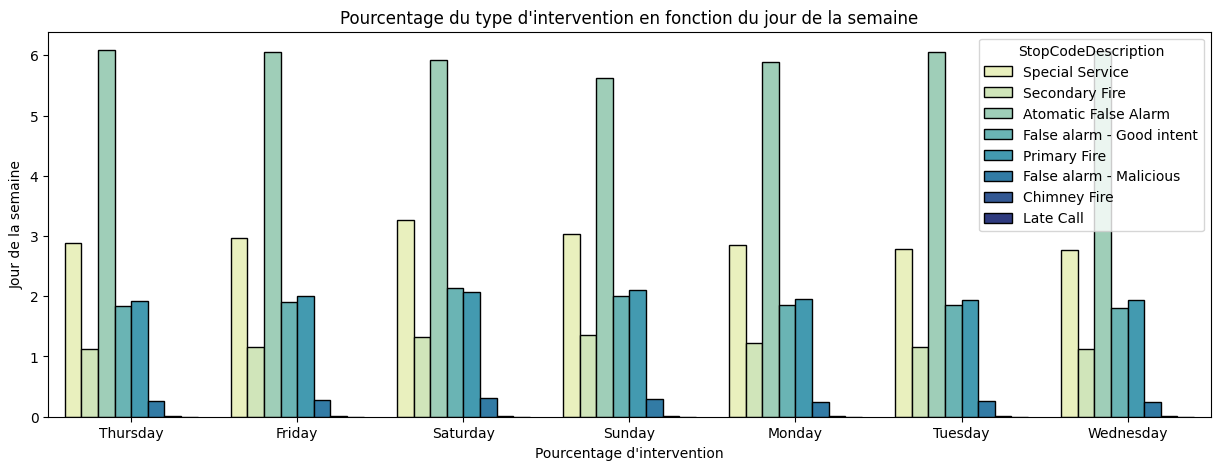

In [26]:
plt.figure(figsize=(15,5))
sns.countplot(data=lfb, x='day_name', hue='StopCodeDescription', orient='h', palette='YlGnBu', stat='percent', edgecolor= 'black')
plt.xlabel("Pourcentage d'intervention")
plt.ylabel("Jour de la semaine")
plt.title("Pourcentage du type d'intervention en fonction du jour de la semaine")
plt.show()

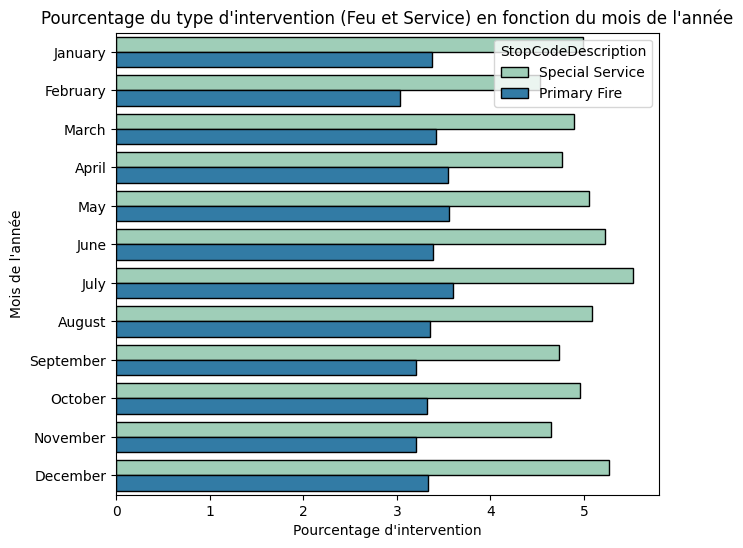

In [27]:
plt.figure(figsize=(7,6))
sns.countplot(data=lfb.loc[(lfb['StopCodeDescription']== 'Primary Fire') | (lfb['StopCodeDescription']== 'Special Service')],
              y='Name_Month', hue= 'StopCodeDescription',palette='YlGnBu', stat='percent', edgecolor= 'black')
plt.xlabel("Pourcentage d'intervention")
plt.ylabel("Mois de l'année")
plt.title("Pourcentage du type d'intervention (Feu et Service) en fonction du mois de l'année")
plt.show()

### <span style="color: #34495e ; margin-left: 40px;">**3.4. Geographique des incidents**</span>

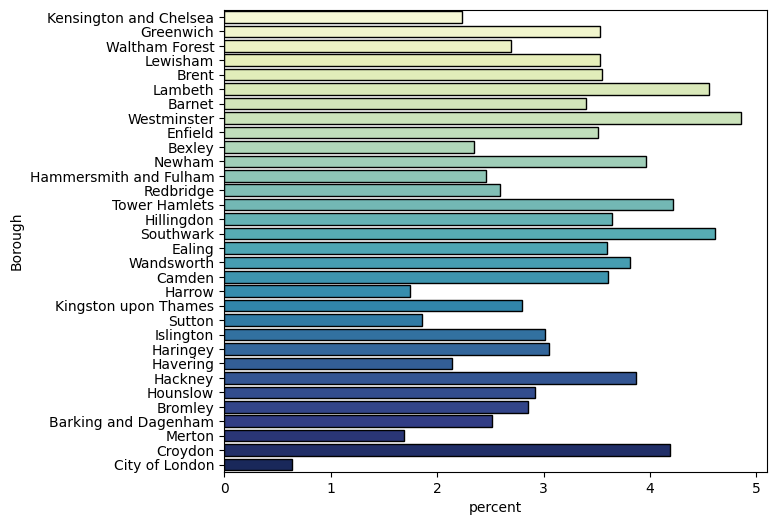

In [28]:

fire_borough = lfb.query("StopCodeDescription == 'Primary Fire'")
plt.figure(figsize=(7,6))
sns.countplot(y= fire_borough['Borough'],hue=fire_borough['Borough'], palette= 'YlGnBu',stat="percent", edgecolor='black')

plt.show()


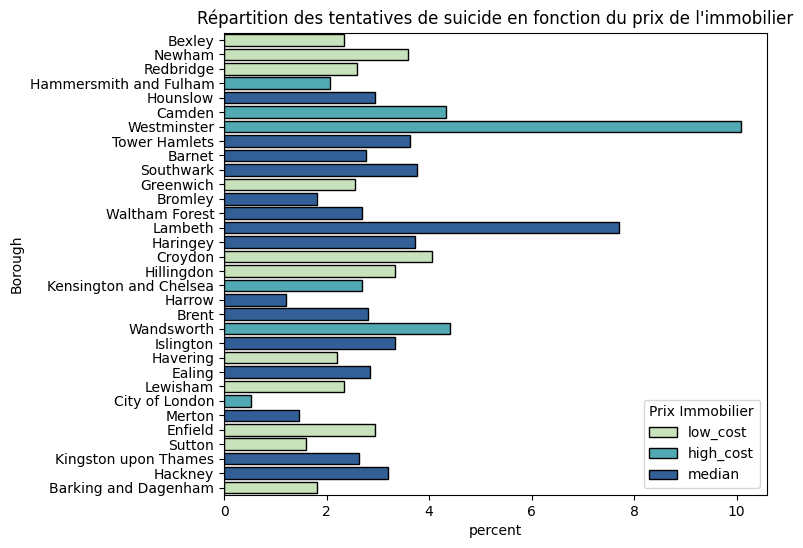

In [29]:
plt.figure(figsize=(7,6))
sns.countplot(data=lfb.query("(SpecialServiceType == 'Suicide/attempts')"), y="Borough",hue="label_price",
              stat='percent',palette='YlGnBu', edgecolor='black')
plt.legend(title="Prix Immobilier")
plt.title('Répartition des tentatives de suicide en fonction du prix de l\'immobilier')
plt.show()

### <span style="color: #34495e ; margin-left: 40px;">**3.5. Geopandas**</span>

In [30]:
path = "../Projet_fil_rouge/Shapefile/ESRI/London_Borough_Excluding_MHW.shp"
shape = gpd.read_file(path)

geo_merge = pd.merge(left= lfb, right= shape, on="GSS_CODE")
lfb_geo = gpd.GeoDataFrame(geo_merge, geometry="geometry")

In [31]:
lfb_geo_fire = lfb_geo.query("StopCodeDescription == 'Primary Fire'").groupby(['Borough',"geometry"]).agg({"IncidentGroup": "count"}).reset_index()

In [32]:
lfb_geo_fire = gpd.GeoDataFrame(lfb_geo_fire,geometry="geometry")
lfb_geo_fire.explore(column='IncidentGroup',tooltip=['Borough'],map_kwds= {"dragging":False, "scrollWheelZoom":False})

In [33]:
test = lfb_geo.groupby(["Borough"]).agg({"response_time": "median"}).reset_index()
lfb_geotime = gpd.GeoDataFrame(pd.merge(left=lfb_geo_fire, right=test, on= "Borough"), geometry='geometry')


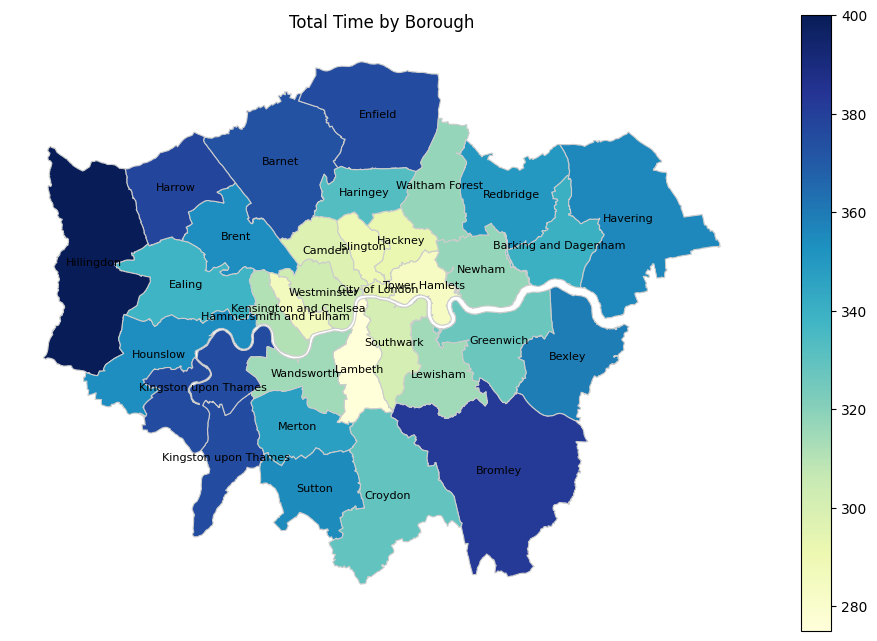

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
lfb_geotime.plot(column='response_time', cmap="YlGnBu", ax=ax, linewidth=0.8, edgecolor='0.8', legend=True)
for x, y, label in zip(lfb_geotime.geometry.centroid.x, lfb_geotime.geometry.centroid.y, lfb_geotime['Borough']):
    ax.text(x, y, label, fontsize=8, ha='center', va='center')
ax.set_title('Total Time by Borough')
ax.set_axis_off()
plt.show()

### <span style="color: #34495e ; margin-left: 40px;">**3.6. WordCloud**</span>

In [35]:
from wordcloud import WordCloud
lfb_sample = lfb.sample(50000)
text = ""

for i in lfb_sample.PropertyType:
    text += i
    


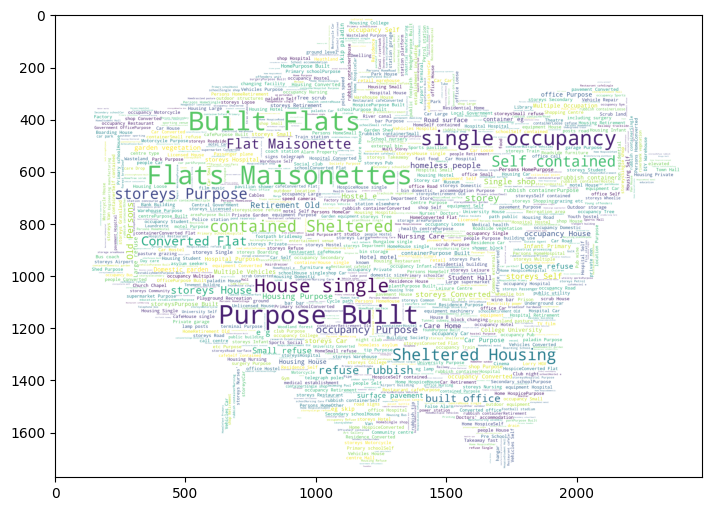

In [36]:
from PIL import Image
def cloud(texte, mask, background_color= "white", colormap="viridis"):
    mask_coloring = np.array(Image.open(str(mask)))
    wc = WordCloud(width=800, height=400, background_color=background_color, max_words=1000, 
                   mask = mask_coloring, colormap=colormap,max_font_size=100, random_state=42)
    plt.figure(figsize=(10,6))
    wc.generate(texte)
    plt.imshow(wc)
    plt.show()
    
cloud(text, "test.jpg")

## <span style="color: #2980b9  ">**4. Statistique** </span>

### <span style="color: #34495e ; margin-left: 40px;">**4.1. Effet de la densité de population sur la durée d'intervention**</span>

In [38]:
# Test hypothèse d'homoscédasticité avec levenne pour la variance inter groupe
import scipy.stats as stats

g1 = lfb.loc[lfb['label_pop'] == "Faible densité"]['Duree_intervention']
g2 = lfb.loc[lfb['label_pop'] == "Dense"]['Duree_intervention']
g3 = lfb.loc[lfb['label_pop'] == "Très dense"]['Duree_intervention']

stat, p = stats.levene(g1, g2, g3, center='median')
print(stat, p)

print(p < 0.05)

502.1833876211024 9.805938881667355e-219
True


In [9]:
# Test hypothèse d'homoscédasticité n'est pas concluant, nous pouvons faire une Anova Robuste 
# pour compenser la violation du test de levenne

import pingouin as pg

anova_robuste = pg.welch_anova(dv = 'Duree_intervention', between="label_pop", data=lfb)
print(anova_robuste)

      Source  ddof1          ddof2           F          p-unc       np2
0  label_pop      2  619326.014191  732.292061  2.213330e-318  0.001218


In [15]:
anova_robuste_df = pd.DataFrame(anova_robuste)

# Arrondir les valeurs numériques à 3 décimales
anova_robuste_df = anova_robuste_df.round(3)
anova_robuste_df.to_csv("anova.csv", index=False)

In [14]:
anova_robuste_df

Source  ddof1       ddof2        F  p-unc    np2
0  label_pop      2  619326.014  732.292    0.0  0.001

In [41]:
from statsmodels.stats.multicomp import MultiComparison

tukey_label_price = MultiComparison(lfb['Duree_intervention'], lfb['label_pop']).tukeyhsd()
print(tukey_label_price)

print("La différence entre la moyenne de faible densité et très dense est la plus importante (165.914) ce qui indique la plus grande magnitude.\n \
On peut affirmer avec moins de 5{%} de se tromper que la durée d'intervention est plus longue dans les zones très dense.")

         Multiple Comparison of Means - Tukey HSD, FWER=0.05         
    group1         group2     meandiff p-adj  lower    upper   reject
---------------------------------------------------------------------
         Dense Faible densité -74.0645   0.0 -82.3219  -65.807   True
         Dense     Très dense  91.8495   0.0  83.1695 100.5296   True
Faible densité     Très dense  165.914   0.0 155.9859 175.8421   True
---------------------------------------------------------------------
La différence entre la moyenne de faible densité et très dense est la plus importante (165.914) ce qui indique la plus grande magnitude.
 On peut affirmer avec moins de 5{%} de se tromper que la durée d'intervention est plus longue dans les zones très dense.


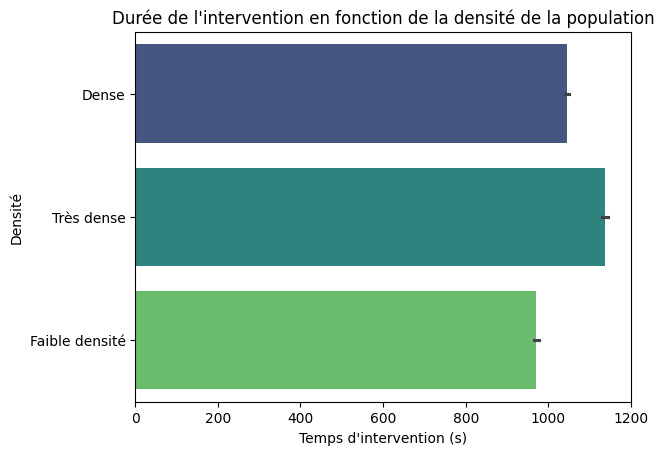

In [42]:
sns.barplot(x = lfb['Duree_intervention'], y= lfb['label_pop'], hue= lfb['label_pop'], palette = 'viridis')
plt.xlabel("Temps d'intervention (s)")
plt.ylabel('Densité')
plt.title("Durée de l'intervention en fonction de la densité de la population")
plt.show()

### <span style="color: #34495e ; margin-left: 40px;">**4.2. Effet de la densité de population et du type d'intervention sur la durée d'intervention**</span>

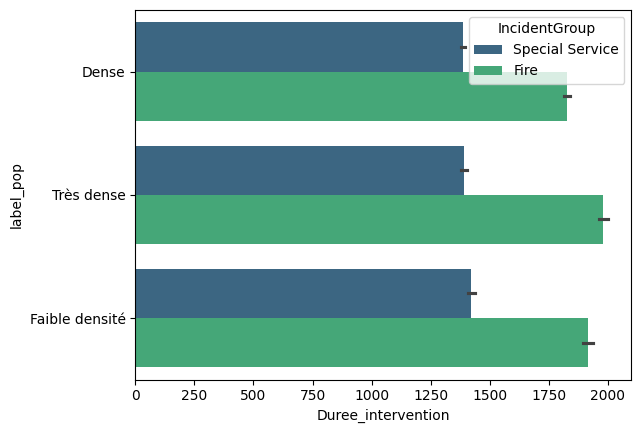

In [43]:
word = ['Special Service', 'Fire']
fire_service= lfb.loc[lfb['IncidentGroup'].isin(word)]
sns.barplot(data= fire_service, x= "Duree_intervention", y="label_pop", hue='IncidentGroup', palette="viridis");

In [44]:
# Test d'interaction entre le prix de l'immobilier et durée d'intervention sur la population 
from statsmodels.formula.api import ols
from statsmodels.stats.api import anova_lm
formula = "Duree_intervention ~ C(label_pop) + C(IncidentGroup) + C(label_pop):C(IncidentGroup)"
model = ols(formula, fire_service).fit()
aov_table = anova_lm(model, type=2)
print(aov_table)


                                     df        sum_sq       mean_sq  \
C(label_pop)                        2.0  7.593881e+08  3.796941e+08   
C(IncidentGroup)                    1.0  3.214827e+10  3.214827e+10   
C(label_pop):C(IncidentGroup)       2.0  5.016234e+08  2.508117e+08   
Residual                       537101.0  2.695411e+12  5.018444e+06   

                                         F        PR(>F)  
C(label_pop)                     75.659714  1.399690e-33  
C(IncidentGroup)               6406.023813  0.000000e+00  
C(label_pop):C(IncidentGroup)    49.977978  1.980885e-22  
Residual                               NaN           NaN  


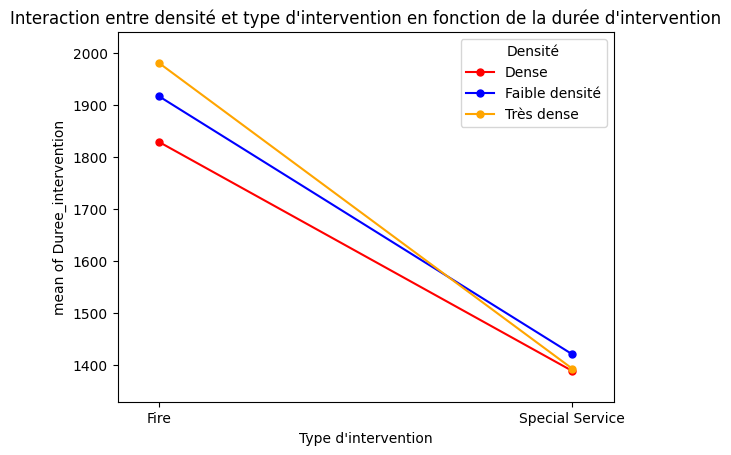

In [45]:
from statsmodels.graphics.factorplots import interaction_plot
fig = interaction_plot(fire_service['IncidentGroup'], fire_service['label_pop'], fire_service['Duree_intervention'], colors=['red','blue', 'orange'], ms=10)
plt.xlabel("Type d'intervention")
plt.legend(title="Densité")
plt.title("Interaction entre densité et type d'intervention en fonction de la durée d'intervention")
plt.show()

### <span style="color: #34495e ; margin-left: 40px;">**4.3. Vitesse d'intervention en fonction du prix de l'immobilier**</span>

In [46]:
# Test hypothèse d'homoscédasticité avec levenne pour la variance inter groupe
import scipy.stats as stats

g1 = lfb.loc[lfb['label_price'] == "low_cost"]['response_time']
g2 = lfb.loc[lfb['label_price'] == "median"]['response_time']
g3 = lfb.loc[lfb['label_price'] == "high_cost"]['response_time']

stat, p = stats.levene(g1, g2, g3, center='median')
print(stat, p)

print(p < 0.05)

2825.765932269937 0.0
True


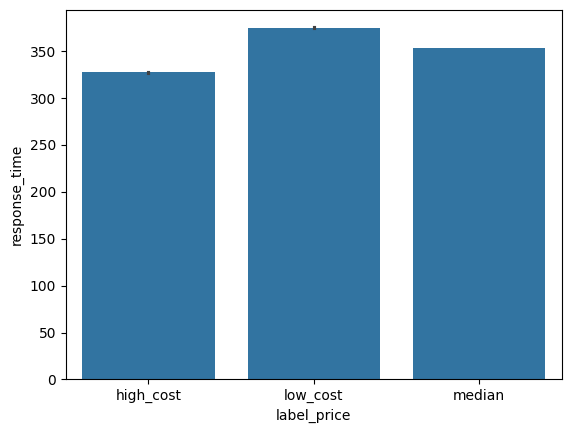

In [47]:
sns.barplot(data = lfb , x="label_price", y="response_time");

In [48]:
# Test hypothèse d'homoscédasticité n'est pas concluant, nous pouvons faire une Anova Robuste 
# pour compenser la violation du test de levenne

import pingouin as pg

anova_robuste = pg.welch_anova(dv = 'response_time', between="label_price", data=lfb)
print(anova_robuste)

        Source  ddof1         ddof2            F  p-unc       np2
0  label_price      2  719569.81696  8462.522158    0.0  0.012325


In [49]:
from statsmodels.stats.multicomp import MultiComparison

tukey_label_price = MultiComparison(lfb['response_time'], lfb['label_price']).tukeyhsd()
print(tukey_label_price)
print("Le meandiff avec le plus de magnitude concerne les zones dont le prix de l'immobilier est élevé vs basse. \nOn peut affirmer avec moins de 5{%} de chance de se tromper que le temps d'intervention est plus rapide pour les zones dont le prix de l'immobilié est élevé.")

   Multiple Comparison of Means - Tukey HSD, FWER=0.05    
  group1   group2  meandiff p-adj  lower    upper   reject
----------------------------------------------------------
high_cost low_cost  47.5005   0.0  46.6121  48.3888   True
high_cost   median  26.0425   0.0  25.2313  26.8537   True
 low_cost   median  -21.458   0.0 -22.2107 -20.7053   True
----------------------------------------------------------
Le meandiff avec le plus de magnitude concerne les zones dont le prix de l'immobilier est élevé vs basse. 
On peut affirmer avec moins de 5{%} de chance de se tromper que le temps d'intervention est plus rapide pour les zones dont le prix de l'immobilié est élevé.


### <span style="color: #34495e ; margin-left: 40px;">**4.4. Vitesse d'intervention en fonction du prix de l'immobilier et population**</span>

In [50]:
# Test d'interaction entre le prix de l'immobilier et durée d'intervention sur la population 

formula = "response_time ~ C(label_price) + C(label_pop) + C(label_pop):C(label_price)"
model = ols(formula, fire_service).fit()
aov_table = anova_lm(model, type=2)
print(aov_table)


                                   df        sum_sq       mean_sq  \
C(label_price)                    2.0  1.115995e+08  5.579975e+07   
C(label_pop)                      2.0  6.126008e+07  3.063004e+07   
C(label_pop):C(label_price)       4.0  9.119951e+07  2.279988e+07   
Residual                     537098.0  1.374522e+10  2.559165e+04   

                                       F  PR(>F)  
C(label_price)               2180.388979     0.0  
C(label_pop)                 1196.876305     0.0  
C(label_pop):C(label_price)   890.910735     0.0  
Residual                             NaN     NaN  


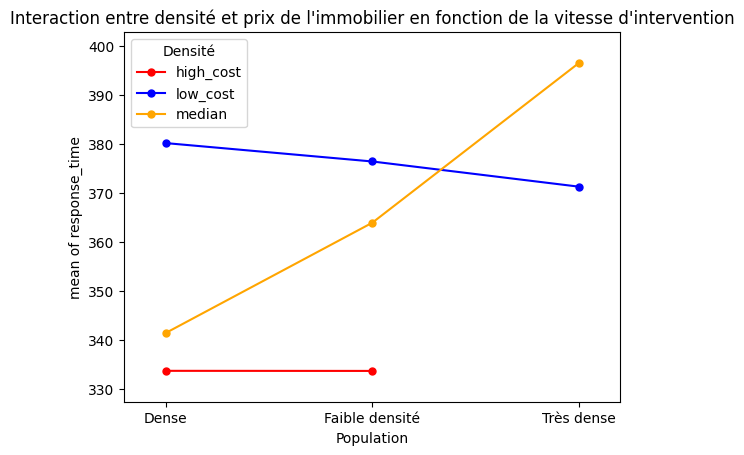

In [51]:
fig = interaction_plot(fire_service['label_pop'], fire_service['label_price'], fire_service['response_time'], colors=['red','blue', 'orange'], ms=10)
plt.xlabel("Population")
plt.legend(title="Densité")
plt.title("Interaction entre densité et prix de l'immobilier en fonction de la vitesse d'intervention")
plt.show()

Text(0.5, 0, 'Population par Borough')

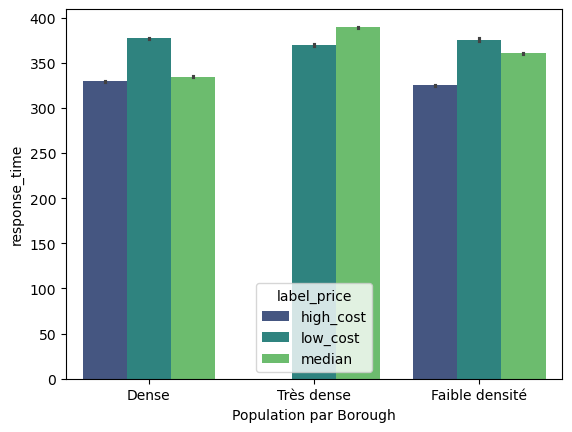

In [ ]:
sns.barplot(x= lfb['label_pop'], y= lfb['response_time'], hue= lfb['label_price'], palette = "viridis")
plt.xlabel("Population par Borough")

## <span style="color: #2980b9  ">**5. Machine Learning** </span>

In [5]:
# Selection feature & target

lfb_ml = lfb[["IncidentGroup", 'HourOfCall',"Notional Cost (£)", 'NumCalls', 'lon', 'lat', "population",\
    "label_price", "Month", "Day", "Label_journee", "NumStationsWithPumpsAttending"]]

lfb_target = lfb[["Label_response","total_label","response_time","Temps_Intervention","Total_Time",\
    "Duree_intervention","Total","mean_per_station", "Duree_inter_label", 'Label_mean_mob']]

liste_target = ["Label_response","total_label","response_time","Temps_Intervention",\
    "Total_Time","Duree_intervention","Total","mean_per_station", "Duree_inter_label", "Label_mean_mob"]

In [42]:
# lfb_ml = lfb[["IncidentGroup", 'HourOfCall',"Notional Cost (£)", 'NumCalls', 'lon', 'lat', "population", "Month", "Day", "NumStationsWithPumpsAttending",
#              "mean_firstPump_arriving", "FirstPumpArriving_AttendanceTime", "SecondPumpArriving_AttendanceTime", "TurnoutTimeSeconds", "TravelTimeSeconds", "AttendanceTimeSeconds"]]

# lfb_target = lfb[["Label_response","total_label","response_time","Temps_Intervention","Total_Time","Duree_intervention","Total","mean_per_station","Duree_inter_label"]]

In [4]:
# lfb_ml = lfb[["IncidentGroup", 'HourOfCall',"Notional Cost (£)", 'NumCalls', 'lon', 'lat', "population", "label_price", "Month", "Day", "Label_journee", "NumStationsWithPumpsAttending",
#              "FirstPumpArriving_AttendanceTime", "SecondPumpArriving_AttendanceTime"]]

# lfb_target = lfb[["Label_response","total_label","response_time","Temps_Intervention","Total_Time","Duree_intervention","Total","mean_per_station", "Duree_inter_label"]]

#liste_target = ["Label_response","total_label","response_time","Temps_Intervention","Total_Time","Duree_intervention","Total","mean_per_station", "Duree_inter_label"]

### <span style="color: #34495e ; margin-left: 40px;">**5.1. Transformation en variable cyclique**</span>

In [7]:
# Transformation de la variable jour de la semaine en variable cyclique

jours_cyclique = np.column_stack([np.sin(2 * np.pi * lfb_ml.Day / 7), np.cos(2 * np.pi * lfb_ml.Day / 7)])
lfb_ml.loc[:,'day_cyclique_x'] = jours_cyclique[:,0]
lfb_ml.loc[:,'day_cyclique_y'] = jours_cyclique[:,1]

# Transformation de la variable mois d'appel en variable cyclique

month_cyclic_x = np.sin(2 * np.pi * lfb_ml.Month / 12)
month_cyclic_y = np.cos(2 * np.pi * lfb_ml.Month / 12)

lfb_ml.loc[:, 'month_x']= month_cyclic_x
lfb_ml.loc[:, 'month_y'] = month_cyclic_y

# Transformation de la variable heure d'appel en variable cyclique

hour_cyclic_x = np.sin(2 * np.pi * lfb_ml.HourOfCall / 24)
hour_cyclic_y = np.cos(2 * np.pi * lfb_ml.HourOfCall  / 24)

lfb_ml.loc[:, 'hour_x']= hour_cyclic_x
lfb_ml.loc[:, 'hour_y'] = hour_cyclic_y


### <span style="color: #34495e ; margin-left: 40px;">**5.2. Preprocessing**</span>

In [20]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler

In [12]:
liste_y = ["Label_response","total_label","response_time","Temps_Intervention","Total_Time","Duree_intervention","Total","mean_per_station", "Duree_inter_label"]
num_target = ["response_time", "Temps_Intervention", "Total_Time", "Duree_intervention", "Total", "mean_per_station"]
cat_target = ["Label_response", "total_label", "Duree_inter_label", "Label_mean_mob"]
X= lfb_ml
y= lfb_target['Label_mean_mob']

In [9]:
def reduction(X, y):
    return X.sample(50000), y[:50000]

def model_selection(X, y, reduction=0, target_label=0):
    if reduction == 1:
        X, y =reduction(X,y)
   
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)
    
    # Separation type de donnée
    X_train_cat = X_train.select_dtypes('object')
    X_test_cat = X_test.select_dtypes('object')

    X_train_num = X_train.select_dtypes(['float', 'int'])
    X_test_num = X_test.select_dtypes(['float', 'int'])
    
    # Preproccessing 
    ohe = OneHotEncoder(drop='first', sparse_output=False).set_output(transform='pandas')

    X_cat_train = ohe.fit_transform(X_train_cat)
    X_cat_test = ohe.transform(X_test_cat)
    
    sc = StandardScaler().set_output(transform="pandas")

    X_num_train = sc.fit_transform(X_train_num)
    X_num_test = sc.transform(X_test_num)
    
    X_train = pd.concat([X_num_train, X_cat_train], axis=1)
    X_test = pd.concat([X_num_test, X_cat_test], axis=1)
    
    if target_label == 1:
        la = LabelEncoder()
        y_train = la.fit_transform(y_train)
        y_test = la.transform(y_test)
    
    return X_train, X_test, y_train, y_test

### <span style="color: #34495e ; margin-left: 40px;">**4.3. Modélisation**</span>

In [21]:
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score

##### <span style="color: #d7dbdd  ; margin-left: 40px;">**4.3.1. DecisionTreeRegressor**</span>

In [13]:
# DecisionTreeRegressor
for i in num_target:
    X_train, X_test, y_train, y_test = model_selection(X, lfb_target[i])
    clf= DecisionTreeRegressor()
    clf.fit(X_train, y_train)
    clf.score(X_test, y_test)
    print("accuracy score de : ", i, "=", clf.score(X_test, y_test))

accuracy score de :  response_time = -0.3563063419198076
accuracy score de :  Temps_Intervention = 0.4983287137178257
accuracy score de :  Total_Time = -0.35759552966057395
accuracy score de :  Duree_intervention = 0.48628649489089393
accuracy score de :  Total = 0.518733274722671
accuracy score de :  mean_per_station = 0.9966508284711438


In [14]:
X_train, X_test, y_train, y_test = model_selection(X, lfb_target["mean_per_station"])
clf = DecisionTreeRegressor()
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.9963913898947552

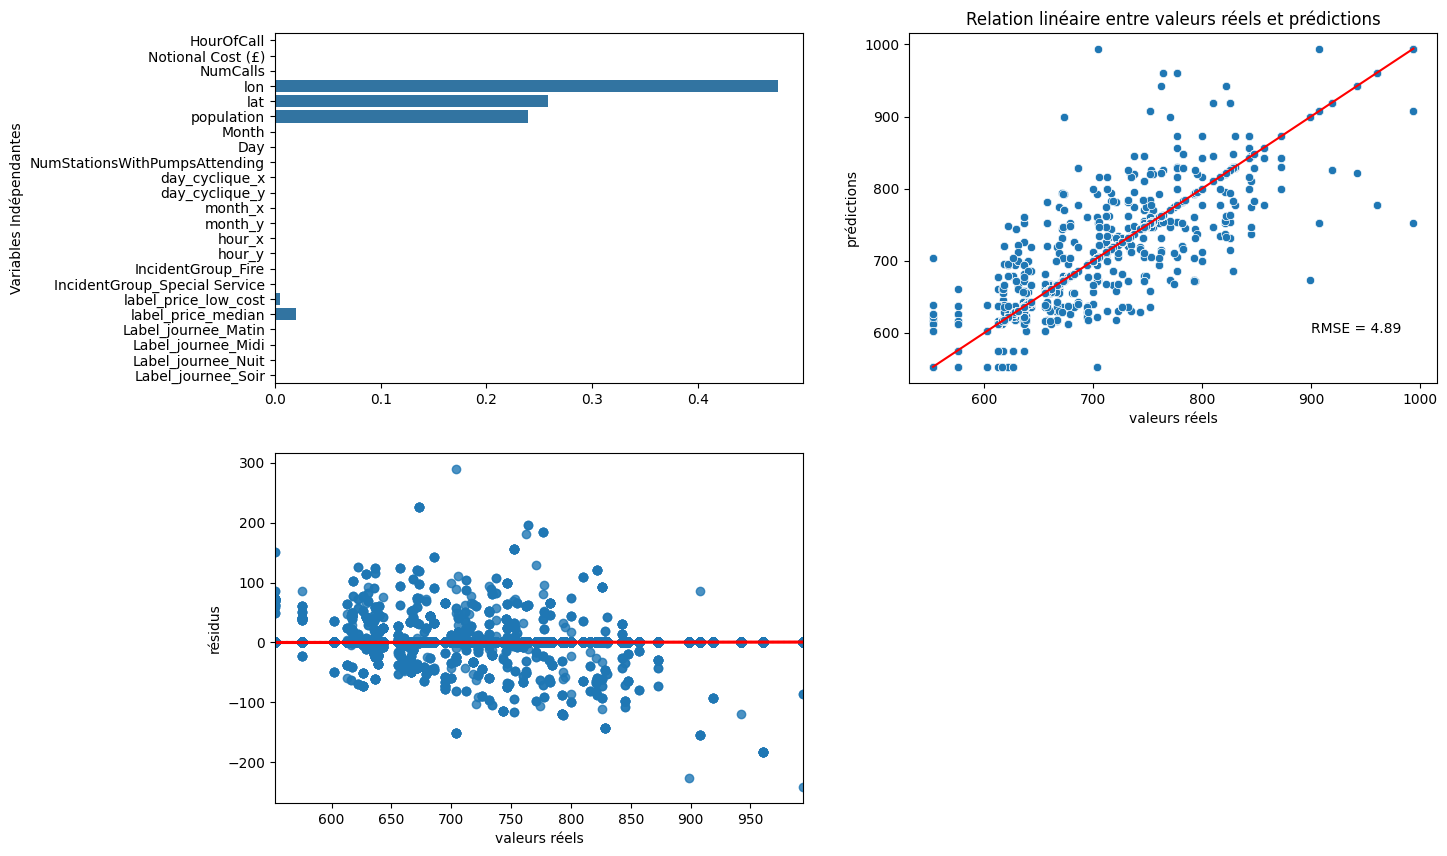

<Figure size 640x480 with 0 Axes>

In [15]:
y_pred_clf = clf.predict(X_test)
rmse = np.round(np.sqrt(mean_squared_error(y_test, y_pred_clf)),2)
plt.figure(figsize=(15,10))
plt.subplot(221)
sns.barplot(x = clf.feature_importances_, y= X_train.columns)
plt.ylabel('Variables Indépendantes')

plt.subplot(222)
sns.scatterplot(x = y_test, y = y_pred_clf)
plt.plot([y_test.min(), y_test.max()], [y_pred_clf.min(), y_pred_clf.max()], "r")
plt.annotate(f"RMSE = {rmse}", (900, 600))
plt.xlabel('valeurs réels')
plt.ylabel('prédictions')
plt.title("Relation linéaire entre valeurs réels et prédictions")

plt.subplot(223)
sns.residplot(x= y_test, y= y_pred_clf, line_kws=dict(color="r"),  lowess=True)
plt.xlabel("valeurs réels")
plt.ylabel("résidus")
plt.show()
plt.tight_layout()


In [18]:
from sklearn.model_selection import learning_curve

In [16]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


ValueError: 
All the 25 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\cleme\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\cleme\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\cleme\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\tree\_classes.py", line 1377, in fit
    super()._fit(
  File "c:\Users\cleme\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\tree\_classes.py", line 252, in _fit
    X, y = self._validate_data(
           ^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\cleme\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 645, in _validate_data
    X = check_array(X, input_name="X", **check_X_params)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\cleme\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py", line 997, in check_array
    array = _asarray_with_order(array, order=order, dtype=dtype, xp=xp)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\cleme\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\_array_api.py", line 521, in _asarray_with_order
    array = numpy.asarray(array, order=order, dtype=dtype)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\cleme\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\generic.py", line 2150, in __array__
    arr = np.asarray(values, dtype=dtype)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ValueError: could not convert string to float: 'False Alarm'

--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\cleme\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\cleme\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\cleme\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\tree\_classes.py", line 1377, in fit
    super()._fit(
  File "c:\Users\cleme\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\tree\_classes.py", line 252, in _fit
    X, y = self._validate_data(
           ^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\cleme\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 645, in _validate_data
    X = check_array(X, input_name="X", **check_X_params)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\cleme\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py", line 997, in check_array
    array = _asarray_with_order(array, order=order, dtype=dtype, xp=xp)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\cleme\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\_array_api.py", line 521, in _asarray_with_order
    array = numpy.asarray(array, order=order, dtype=dtype)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\cleme\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\generic.py", line 2150, in __array__
    arr = np.asarray(values, dtype=dtype)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ValueError: could not convert string to float: 'Special Service'


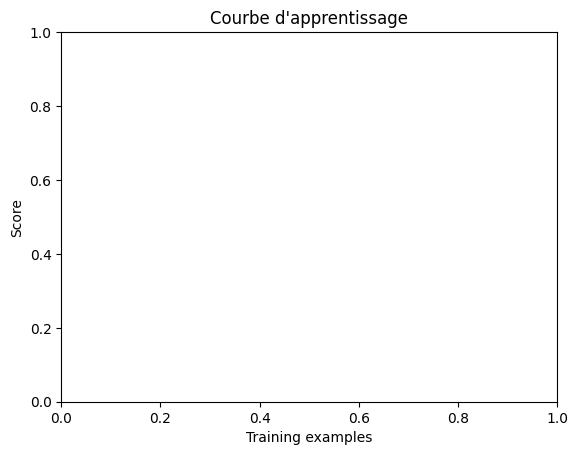

In [19]:
title = "Courbe d'apprentissage"
plot_learning_curve(clf, title, X, lfb_target["mean_per_station"], cv=None, n_jobs=-1)
plt.show()


##### <span style="color: #d7dbdd  ; margin-left: 40px;">**4.3.2. DecisionTreeClassifier**</span>

In [35]:
for i in cat_target:
    X_train, X_test, y_train, y_test = model_selection(X,lfb_target[i])
    clf_cla= DecisionTreeClassifier()
    clf_cla.fit(X_train, y_train)
    clf_cla.score(X_test, y_test)
    print("accuracy score de : ", i, "=", clf_cla.score(X_test, y_test))

accuracy score de :  Label_response = 0.5267247132098255
accuracy score de :  total_label = 0.6081302233944517
accuracy score de :  Duree_inter_label = 0.5410721662588579
accuracy score de :  Label_mean_mob = 0.9973148177571578


In [46]:
X_train, X_test, y_train, y_test = model_selection(X,lfb_target["Label_mean_mob"], target_label=1)

clf_cla = DecisionTreeClassifier()
clf_cla.fit(X_train, y_train)
clf_cla.score(X_test, y_test)

['fast_mob' 'low_mob' 'mean_mob']


0.9972353744955353

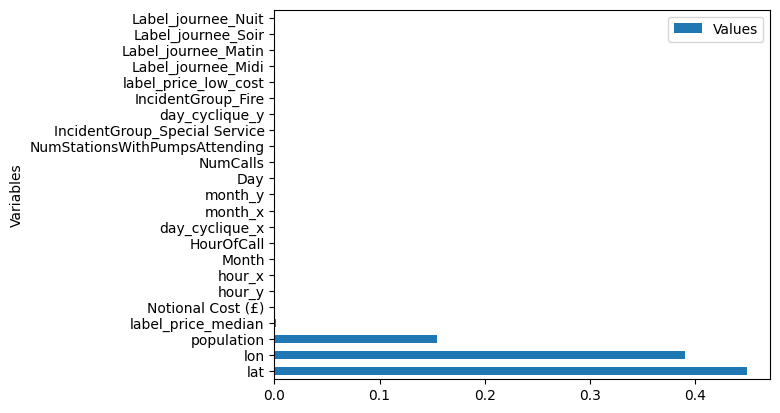

In [47]:
importance = pd.DataFrame({"Variables": X_train.columns, "Values": clf_cla.feature_importances_}).sort_values(by="Values", ascending=False).plot("Variables", 'Values',kind='barh')


**GridSearch with DecisionTreeClassifier**

In [20]:
# Target Temps total d'intervention

param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10]
}

clf = DecisionTreeClassifier(random_state=42)

grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, scoring='accuracy')

grid_search.fit(X_train, y_train)

print(grid_search.score(X_test, y_test), grid_search.best_params_)





KeyboardInterrupt: 

In [57]:
from sklearn.metrics import accuracy_score
best_clf = grid_search.best_estimator_
y_pred = best_clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(accuracy)


0.6664534939146461


In [58]:
pd.crosstab(y_test, y_pred)

col_0        longue  normale  rapide
total_label                         
longue        34478    25372    2850
normale        6192    99527   20288
rapide          357    28912   33776

**Pipeline with DecisionTreeClassifier**

In [ ]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer

num_col = X_train_num.columns
cat_col = X_train_cat.columns

num_pipeline = make_pipeline(StandardScaler())
cat_pipeline = make_pipeline(OneHotEncoder(drop='first', sparse_output=False))
preprocessor = make_column_transformer((num_pipeline, num_col),
                                      (cat_pipeline, cat_col))
model = make_pipeline(preprocessor, DecisionTreeClassifier())
model.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['HourOfCall', 'Notional Cost (£)', 'NumCalls', 'lon', 'lat',
       'population', 'Month', 'Day', 'NumStationsWithPumpsAttending',
       'mean_firstPump_arriving', 'FirstPumpArriving_AttendanceTime',
       'SecondPumpArriving_AttendanceTime', 'day_cyclique_x', 'day_cyclique_y',
       'month_x', 'month_y', 'hour_x', 'hour_y'],
      dtype='object')),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse_output=False))]),
                                                  Index(['IncidentGroup', 'label_price', 'Label_journee'], dtype='object'))])),
                ('decisiontreeclassifier', DecisionTreeClassifier())])

In [ ]:
model.score(X_test, y_test)

0.6333693476119355

**Support Vector Machine**

In [14]:
from sklearn.svm import SVC

X_train, X_test, y_train, y_test = model_selection(X, y, 1)
svc = SVC()
svc.fit(X_train, y_train)
svc.score(X_test,y_test)

0.4948

**AdaBoostClassifier**

In [16]:
from sklearn.ensemble import AdaBoostClassifier
X_train, X_test, y_train, y_test = model_selection(X, y, 0)
ad = AdaBoostClassifier()
ad.fit(X_train, y_train)
ad.score(X_test, y_test)

c:\Users\cleme\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


0.6580285360195748

In [14]:
from sklearn.ensemble import AdaBoostRegressor

X_train, X_test, y_train, y_test = model_selection(X, lfb_target['Total'])

ad_reg = AdaBoostRegressor()
ad_reg.fit(X_train, y_train)
ad_reg.score(X_test, y_test)

0.6303904920981525

In [ ]:
grad = GradientBoostingClassifier()
grad.fit(X_train, y_train)
grad.score(X_test, y_test)

0.6008849979344753

In [90]:
X_train, X_test, y_train, y_test = model_selection(X, y)

param_grid = {
    'n_estimators': [50, 100],  # Nombre d'arbres dans le modèle
    'learning_rate': [0.001,0.1, 0.2],  # Taux d'apprentissage
    'max_depth': [3, 4, 5]  # Profondeur maximale des arbres
}

grad_clf = GradientBoostingClassifier()


grid_search = GridSearchCV(grad_clf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)


grid_search.fit(X_train, y_train)

KeyboardInterrupt: 

In [88]:
grid_search.score(X_test, y_test)

0.50225

##### <span style="color: #d7dbdd  ; margin-left: 40px;">**4.3.3. AdaBoostRegressor**</span>

In [92]:
liste_num = ["response_time", "Temps_Intervention", "Total_Time", "Duree_intervention", 'Total', "mean_per_station"]
for i in liste_num:
    X_train, X_test, y_train, y_test = model_selection(X, lfb_target[i])
    ad_reg = AdaBoostRegressor()
    ad_reg.fit(X_train, y_train)
    print("accuracy", i, ad_reg.score(X_test, y_test))



accuracy response_time -0.6527292685170167
accuracy Temps_Intervention 0.6245097774345993
accuracy Total_Time -0.13697370442850776
accuracy Duree_intervention 0.6401003248070164
accuracy Total 0.6130287475956042
accuracy mean_per_station 0.6960775067597971


##### <span style="color: #d7dbdd  ; margin-left: 40px;">**4.3.4. XGBoost**</span>

In [10]:
import xgboost as xgb
from xgboost import XGBRegressor

##### <span style="color:  #f1c40f   ; margin-left: 40px;">**4.3.4.1. XGBRegressor**</span>

In [35]:
liste_num = ["response_time", "Temps_Intervention", "Total_Time", "Duree_intervention", 'Total', "mean_per_station"]

for i in liste_num:
    X_train, X_test, y_train, y_test = model_selection(X,lfb_target[i])
    xg = XGBRegressor()
    xg.fit(X_train, y_train)
    print("Score Accuracy de ", i, ': ', xg.score(X_test, y_test))

Score Accuracy de  response_time :  0.7654389575754682
Score Accuracy de  Temps_Intervention :  0.7586631124315664
Score Accuracy de  Total_Time :  0.765021330410886
Score Accuracy de  Duree_intervention :  0.7571815559267643
Score Accuracy de  Total :  0.7636733082195598
Score Accuracy de  mean_per_station :  0.982263610935557


**Target mean_per_station**

In [37]:
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_depth': [3, 5, 7],            # Maximum depth of each tree
    'learning_rate': [0.01, 0.1, 0.3], # Learning rate
}
X_train, X_test, y_train, y_test = model_selection(X,lfb_target["mean_per_station"])

grid_xgb = GridSearchCV(estimator=XGBRegressor(), param_grid=param_grid)

grid_xgb.fit(X_train, y_train)
print("Score: ",grid_xgb.score(X_test, y_test), "Best params: ",grid_xgb.best_params_)

Score:  0.9916087930903404 Best params:  {'learning_rate': 0.3, 'max_depth': 7, 'n_estimators': 300}


In [11]:
X_train, X_test, y_train, y_test = model_selection(X,lfb_target["mean_per_station"])

model_xgb = XGBRegressor(eta= 0.3, max_depth= 7, n_estimators=300)
model_xgb.fit(X_train, y_train)
print("score train = ", model_xgb.score(X_train, y_train))
print("score test = ", model_xgb.score(X_test, y_test))
y_pred_xgb = model_xgb.predict(X_test)

score train =  0.9939967251021183
score test =  0.9920575980584874


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

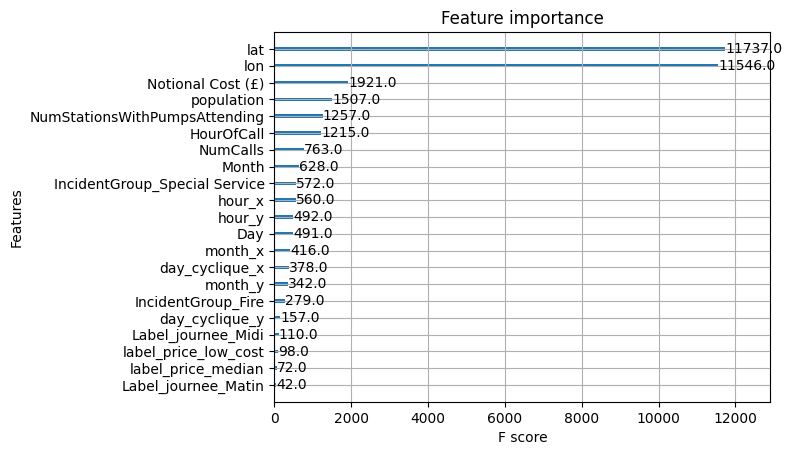

In [12]:
xgb.plot_importance(model_xgb)

In [14]:
def mape(y_true, y_pred):
    # Mean Absolute Percentage Error
    return np.round(np.mean(np.abs((y_true - y_pred) / y_true)) * 100,2)
mape_xgb = mape(y_test, y_pred_xgb)

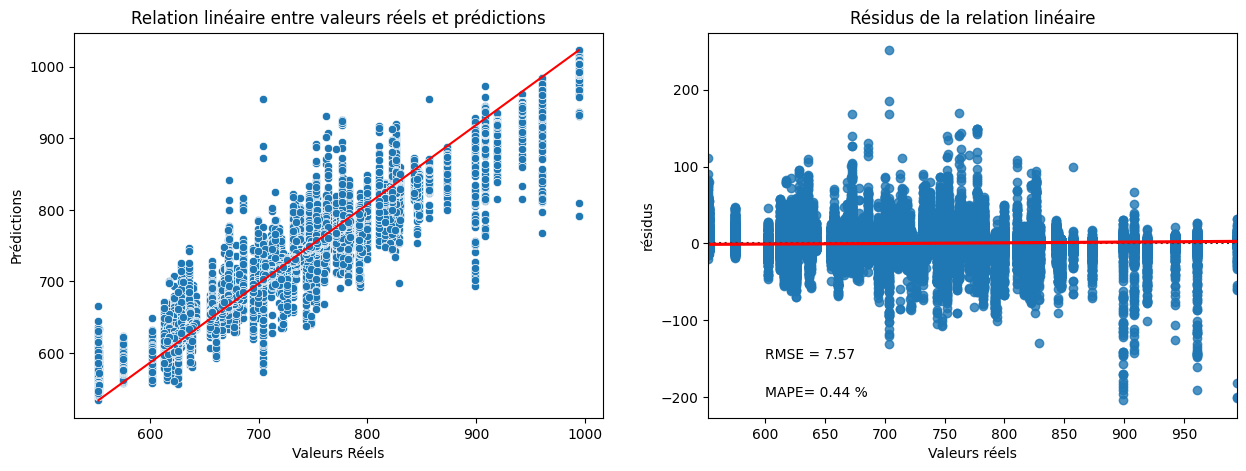

In [15]:
rmse_xbg = np.round(np.sqrt(mean_squared_error(y_test, y_pred_xgb)), 2)

plt.figure(figsize=(15,5))

plt.subplot(121)
sns.scatterplot(x= y_test, y= y_pred_xgb)
plt.plot([y_test.min(), y_test.max()], [y_pred_xgb.min(), y_pred_xgb.max()], "r")
plt.xlabel('Valeurs Réels')
plt.ylabel("Prédictions")
plt.title("Relation linéaire entre valeurs réels et prédictions")

plt.subplot(122)
sns.residplot(x= y_test, y= y_pred_xgb, line_kws=dict(color= "r"), lowess=True)
plt.annotate(f'RMSE = {rmse_xbg}', (600,-150))
plt.annotate(f'MAPE= {np.round(mape_xgb,2)} %', (600,-200))
plt.xlabel('Valeurs réels')
plt.ylabel('résidus')
plt.title('Résidus de la relation linéaire')
plt.show()

##### <span style="color:  #f1c40f   ; margin-left: 40px;">**4.3.4.2. XGBClassifier**</span>

In [16]:
from xgboost import XGBRFClassifier

liste_cat = ["Label_response","total_label","Duree_inter_label"]


for i in liste_cat:
    X_train, X_test, y_train, y_test = model_selection(X,lfb_target[i],target_label=1)
    xg = XGBRFClassifier()
    xg.fit(X_train, y_train)
    print("Score Accuracy de ", i, ': ', xg.score(X_test, y_test))

['fast_time' 'low_time' 'mean_time']
Score Accuracy de  Label_response :  0.8681639073373797
['longue' 'normale' 'rapide']
Score Accuracy de  total_label :  0.6596809558613238
['courte' 'longue' 'moyenne']
Score Accuracy de  Duree_inter_label :  0.5998045695764085


In [17]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

In [34]:
X_train, X_test, y_train, y_test = model_selection(X, lfb_target['Label_response'], target_label=1)

param_grid = {
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200, 300]
}


xgb_clf = XGBClassifier()

grid_search = GridSearchCV(estimator=xgb_clf, param_grid=param_grid, scoring='accuracy', cv=5, n_jobs=-1)

grid_search.fit(X_train, y_train)


print("Meilleurs paramètres trouvés : ", grid_search.best_params_)
print("Meilleur score de validation croisée : ", grid_search.best_score_)


Meilleurs paramètres trouvés :  {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Meilleur score de validation croisée :  0.8681281587337061


In [19]:
X_train, X_test, y_train, y_test = model_selection(X, lfb_target['Label_response'], target_label=1)

model_xgb_clf = XGBClassifier(eta= 0.1, max_depth = 3, n_estimators= 100)
model_xgb_clf.fit(X_train, y_train)


y_pred_xgb_clf = model_xgb_clf.predict(X_test)

accuracy_score(y_test, y_pred_xgb_clf)



['fast_time' 'low_time' 'mean_time']


0.8678223013124027

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

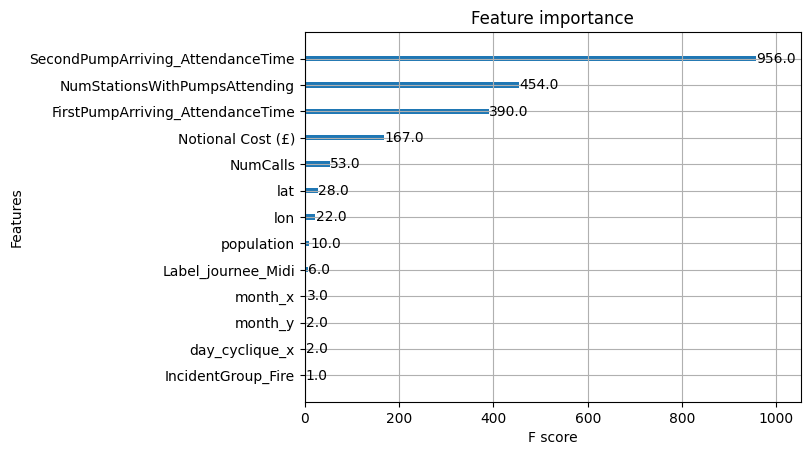

In [20]:
xgb.plot_importance(model_xgb_clf)

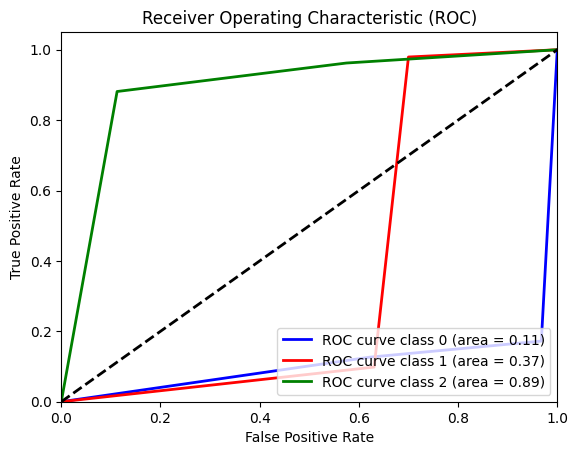

In [21]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

y_test_binary = label_binarize(y_test, classes=[0, 1, 2])

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):  
    fpr[i], tpr[i], _ = roc_curve(y_test_binary[:, i], y_pred_xgb_clf) 
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
colors = ['blue', 'red', 'green']
for i, color in zip(range(3), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label='ROC curve class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


In [22]:
matrice_confusion = pd.crosstab(y_test, y_pred_xgb_clf, rownames=['GoldStd'], colnames=['Prediction'])
matrice_confusion = matrice_confusion.rename(columns={0: "fast_time", 1: "low_time", 2:'mean_time'}, index={0: "fast_time", 1: "low_time", 2:'mean_time'})
matrice_confusion

Prediction  fast_time  low_time  mean_time
GoldStd                                   
fast_time       51994      2866       7953
low_time         1296     55080       6154
mean_time        4777     10230     111402

In [23]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred_xgb_clf))

print("La classe 0 fast_time detecte bien la classe mais discrimine mal.\nLa classe 1 low_time profil inverse de 0.\nLa classe 2 semble plus équilibré.")

              precision    recall  f1-score   support

           0       0.90      0.83      0.86     62813
           1       0.81      0.88      0.84     62530
           2       0.89      0.88      0.88    126409

    accuracy                           0.87    251752
   macro avg       0.86      0.86      0.86    251752
weighted avg       0.87      0.87      0.87    251752

La classe 0 fast_time detecte bien la classe mais discrimine mal.
La classe 1 low_time profil inverse de 0.
La classe 2 semble plus équilibré.


##### <span style="color:  #f1c40f   ; margin-left: 40px;">**4.3.4.3. XGBRegressor Fire**</span>

In [25]:
lfb_fire = lfb.loc[lfb['IncidentGroup']== 'Fire']
target = lfb_fire[num_target + cat_target]
lfb_fire  = lfb_fire[["IncidentGroup", 'HourOfCall',"Notional Cost (£)", 'NumCalls', 'lon', 'lat', "population", "label_price", "Month", "Day", "Label_journee", "NumStationsWithPumpsAttending",
              "FirstPumpArriving_AttendanceTime", "SecondPumpArriving_AttendanceTime"]]


jours_cyclique = np.column_stack([np.sin(2 * np.pi * lfb_fire.Day / 7), np.cos(2 * np.pi * lfb_fire.Day / 7)])
lfb_fire.loc[:,'day_cyclique_x'] = jours_cyclique[:,0]
lfb_fire.loc[:,'day_cyclique_y'] = jours_cyclique[:,1]

# Transformation de la variable mois d'appel en variable cyclique

month_cyclic_x = np.sin(2 * np.pi * lfb_fire.Month / 12)
month_cyclic_y = np.cos(2 * np.pi * lfb_fire.Month / 12)

lfb_fire.loc[:, 'month_x']= month_cyclic_x
lfb_fire.loc[:, 'month_y'] = month_cyclic_y

# Transformation de la variable heure d'appel en variable cyclique

hour_cyclic_x = np.sin(2 * np.pi * lfb_fire.HourOfCall / 24)
hour_cyclic_y = np.cos(2 * np.pi * lfb_fire.HourOfCall  / 24)

lfb_fire.loc[:, 'hour_x']= hour_cyclic_x
lfb_fire.loc[:, 'hour_y'] = hour_cyclic_y

lfb_fire = lfb_fire.drop(columns=["Month", "Day", "HourOfCall", "IncidentGroup"], axis=1)
feature = lfb_fire

In [100]:
num_target
for i in num_target:
    X_train, X_test, y_train, y_test = model_selection(feature, target[i])
    regressor = XGBRegressor()
    regressor.fit(X_train, y_train)
    print("Score de ",i,' =',regressor.score(X_test, y_test))


Score de  response_time  = 0.6986342052200185
Score de  Temps_Intervention  = 0.765477514126387
Score de  Total_Time  = 0.6890198704365729
Score de  Duree_intervention  = 0.7614448699249692
Score de  Total  = 0.7830214234113735
Score de  mean_per_station  = 0.9774502036036775


##### <span style="color:  #f1c40f   ; margin-left: 40px;">**4.3.4.4. XGBRegressor Special Service**</span>

In [35]:
lfb_fire = lfb.loc[lfb['IncidentGroup']== 'Special Service']
target = lfb_fire[num_target + cat_target]
lfb_fire  = lfb_fire[["IncidentGroup", 'HourOfCall',"Notional Cost (£)", 'NumCalls', 'lon', 'lat', "population", "label_price", "Month", "Day", "Label_journee", "NumStationsWithPumpsAttending",
              "FirstPumpArriving_AttendanceTime", "SecondPumpArriving_AttendanceTime"]]


jours_cyclique = np.column_stack([np.sin(2 * np.pi * lfb_fire.Day / 7), np.cos(2 * np.pi * lfb_fire.Day / 7)])
lfb_fire.loc[:,'day_cyclique_x'] = jours_cyclique[:,0]
lfb_fire.loc[:,'day_cyclique_y'] = jours_cyclique[:,1]

# Transformation de la variable mois d'appel en variable cyclique

month_cyclic_x = np.sin(2 * np.pi * lfb_fire.Month / 12)
month_cyclic_y = np.cos(2 * np.pi * lfb_fire.Month / 12)

lfb_fire.loc[:, 'month_x']= month_cyclic_x
lfb_fire.loc[:, 'month_y'] = month_cyclic_y

# Transformation de la variable heure d'appel en variable cyclique

hour_cyclic_x = np.sin(2 * np.pi * lfb_fire.HourOfCall / 24)
hour_cyclic_y = np.cos(2 * np.pi * lfb_fire.HourOfCall  / 24)

lfb_fire.loc[:, 'hour_x']= hour_cyclic_x
lfb_fire.loc[:, 'hour_y'] = hour_cyclic_y

lfb_fire = lfb_fire.drop(columns=["Month", "Day", "HourOfCall", "IncidentGroup"], axis=1)
feature = lfb_fire

In [36]:
num_target
for i in num_target:
    X_train, X_test, y_train, y_test = model_selection(feature, target[i])
    regressor = XGBRegressor()
    regressor.fit(X_train, y_train)
    print("Score de ",i,' =',regressor.score(X_test, y_test))

Score de  response_time  = 0.839815243890897
Score de  Temps_Intervention  = 0.7395799145910473
Score de  Total_Time  = 0.8423745778522498
Score de  Duree_intervention  = 0.745134822466489
Score de  Total  = 0.7641432836950948
Score de  mean_per_station  = 0.9813442344122837


**Target Total_Time**

In [106]:
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_depth': [3, 5, 7],            # Maximum depth of each tree
    'learning_rate': [0.01, 0.1, 0.3], # Learning rate
}
X_train, X_test, y_train, y_test = model_selection(feature,target["Total_Time"])

grid_ss_xgb = GridSearchCV(estimator=XGBRegressor(), param_grid=param_grid)

grid_ss_xgb.fit(X_train, y_train)
print("Score: ",grid_ss_xgb.score(X_test, y_test), "Best params: ",grid_ss_xgb.best_params_)

Score:  0.8757192675515426 Best params:  {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}


In [75]:
X_train, X_test, y_train, y_test = model_selection(feature,target["Total_Time"])
model_ss_xgb = XGBRegressor(eta= 0.1, max_depth= 3, n_estimators= 100)
model_ss_xgb.fit(X_train, y_train)
print("train =", model_ss_xgb.score(X_train, y_train), "test = ",model_ss_xgb.score(X_test, y_test))


train = 0.8769232726513785 test =  0.8733025329499784


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

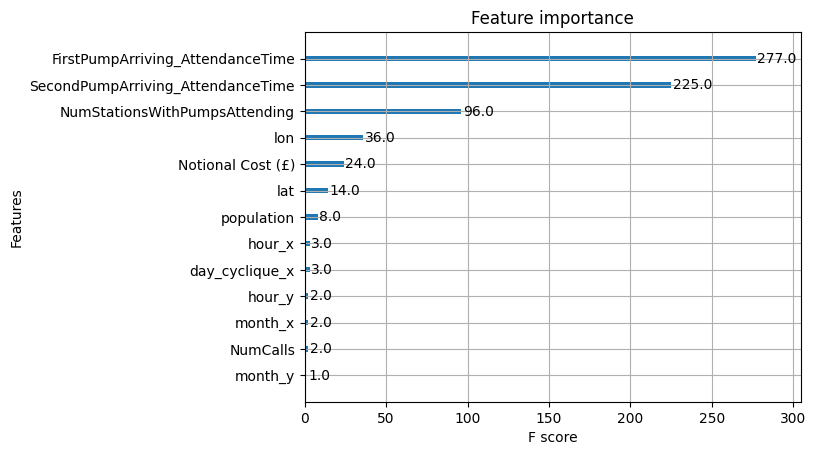

In [76]:
xgb.plot_importance(model_ss_xgb)

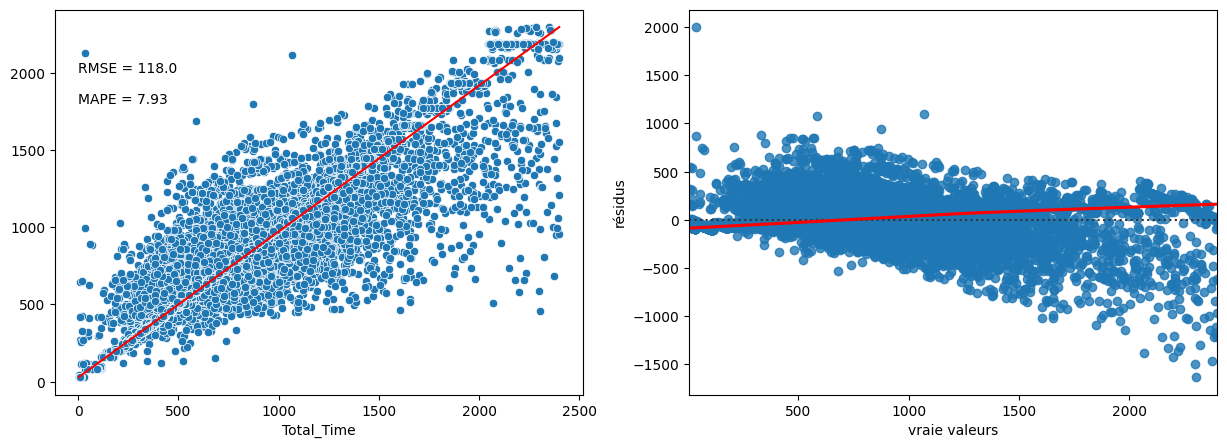

In [77]:
y_pred_ss = model_ss_xgb.predict(X_test)
rmse_ss = np.round(np.sqrt(mean_squared_error(y_test, y_pred_ss)))
mape_ss = mape(y_test, y_pred_ss)

plt.figure(figsize=(15,5))

plt.subplot(121)
sns.scatterplot(x= y_test, y= y_pred_ss)
plt.plot([y_test.min(), y_test.max()], [y_pred_ss.min(), y_pred_ss.max()], "r")
plt.annotate(f'RMSE = {rmse_ss}', (0, 2000))
plt.annotate(f'MAPE = {mape_ss}', (0, 1800))

plt.subplot(122)
sns.residplot(x= y_test, y = y_pred_ss, lowess=True, line_kws=dict(color='r'))
plt.xlabel("vraie valeurs")
plt.ylabel("résidus")
plt.show()

**Target Total**

In [40]:
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_depth': [3, 5, 7],            # Maximum depth of each tree
    'learning_rate': [0.01, 0.1, 0.3], # Learning rate
}
X_train, X_test, y_train, y_test = model_selection(feature,target["Total"])

grid_ss_xgb_total = GridSearchCV(estimator=XGBRegressor(), param_grid=param_grid)

grid_ss_xgb_total.fit(X_train, y_train)
print("Score: ",grid_ss_xgb_total.score(X_test, y_test), "Best params: ",grid_ss_xgb_total.best_params_)

Score:  0.7727123444078137 Best params:  {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}


In [80]:
X_train, X_test, y_train, y_test = model_selection(feature,target["Total"])
model_ss_total = XGBRegressor(eta= 0.1, max_depth = 5, n_estimators = 200)
model_ss_total.fit(X_train, y_train)
model_ss_total.score(X_test, y_test)

0.7649039775620166

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

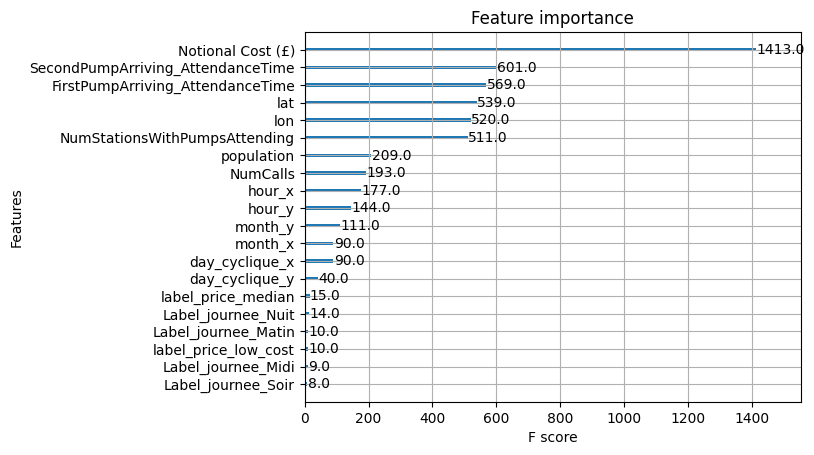

In [81]:
xgb.plot_importance(model_ss_total)

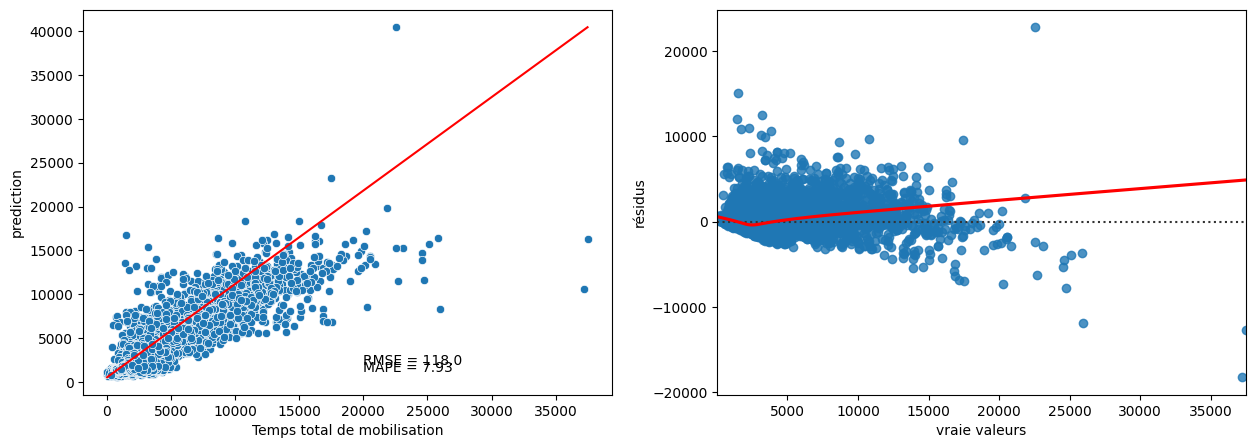

In [82]:
y_pred_ss_total = model_ss_total.predict(X_test)
rmse_ss_total = np.round(np.sqrt(mean_squared_error(y_test, y_pred_ss_total)))
mape_ss_total = mape(y_test, y_pred_ss_total)

plt.figure(figsize = (15,5))

plt.subplot(121)
sns.scatterplot(x= y_test, y= y_pred_ss_total)
plt.plot([y_test.min(), y_test.max()], [y_pred_ss_total.min(), y_pred_ss_total.max()], "r")
plt.annotate(f'RMSE = {rmse_ss}', (20000, 2000))
plt.annotate(f'MAPE = {mape_ss}', (20000, 1200))
plt.xlabel("Temps total de mobilisation")
plt.ylabel("prediction")

plt.subplot(122)
sns.residplot(x= y_test, y = y_pred_ss_total, lowess=True, line_kws=dict(color='r'))
plt.xlabel("vraie valeurs")
plt.ylabel("résidus")
plt.show()

## <span style="color: #2980b9  ">**6. Streamlit** </span>

##### <span style="color: #d7dbdd  ; margin-left: 40px;">**6.1. DecisionTreeRegressor**</span>

In [85]:
X_train, X_test, y_train, y_test = model_selection(X, lfb_target["mean_per_station"])
clf = DecisionTreeRegressor()
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.996375814648035

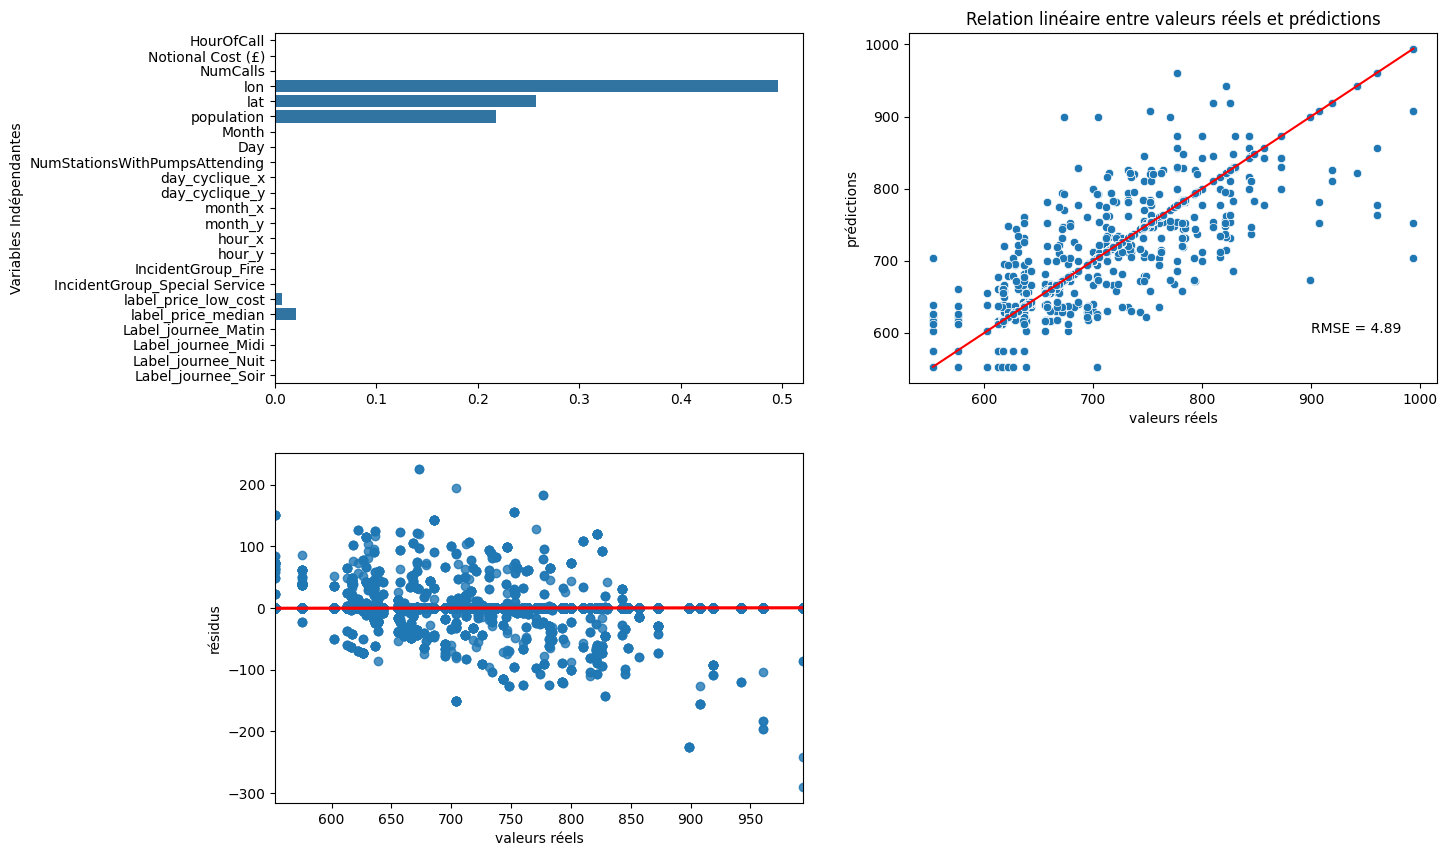

<Figure size 640x480 with 0 Axes>

In [86]:
y_pred_clf = clf.predict(X_test)
rmse = np.round(np.sqrt(mean_squared_error(y_test, y_pred_clf)),2)
plt.figure(figsize=(15,10))
plt.subplot(221)
sns.barplot(x = clf.feature_importances_, y= X_train.columns)
plt.ylabel('Variables Indépendantes')

plt.subplot(222)
sns.scatterplot(x = y_test, y = y_pred_clf)
plt.plot([y_test.min(), y_test.max()], [y_pred_clf.min(), y_pred_clf.max()], "r")
plt.annotate(f"RMSE = {rmse}", (900, 600))
plt.xlabel('valeurs réels')
plt.ylabel('prédictions')
plt.title("Relation linéaire entre valeurs réels et prédictions")

plt.subplot(223)
sns.residplot(x= y_test, y= y_pred_clf, line_kws=dict(color="r"),  lowess=True)
plt.xlabel("valeurs réels")
plt.ylabel("résidus")
plt.show()
plt.tight_layout()


##### <span style="color: #d7dbdd  ; margin-left: 40px;">**6.2. DecisionTreeClassifier**</span>

In [68]:
X_train, X_test, y_train, y_test = model_selection(X,lfb_target["Label_mean_mob"])

la = LabelEncoder()
la.fit_transform(y_train)
la.transform(y_test)

clf_cla = DecisionTreeClassifier()
clf_cla.fit(X_train, y_train)
clf_cla.score(X_test, y_test)

0.9971877085385618

In [69]:
y_pred_cla = clf_cla.predict(X_test)
print(np.unique(y_pred_cla), la.transform(np.unique(y_pred_cla)))

['fast_mob' 'low_mob' 'mean_mob'] [0 1 2]


In [72]:
from sklearn.metrics import classification_report

matrice_con = pd.crosstab(y_test, y_pred_cla, rownames=['True'], colnames=['Predict'])

display(matrice_con)

print(classification_report(y_test, y_pred_cla))


Predict   fast_mob  low_mob  mean_mob
True                                 
fast_mob     63139        1       184
low_mob          1    62170       170
mean_mob       206      146    125735

              precision    recall  f1-score   support

    fast_mob       1.00      1.00      1.00     63324
     low_mob       1.00      1.00      1.00     62341
    mean_mob       1.00      1.00      1.00    126087

    accuracy                           1.00    251752
   macro avg       1.00      1.00      1.00    251752
weighted avg       1.00      1.00      1.00    251752



In [81]:
lfb['mean_per_station'].describe()

count    1.258760e+06
mean     7.064581e+02
std      8.133621e+01
min      5.526900e+02
25%      6.396100e+02
50%      6.945200e+02
75%      7.533300e+02
max      9.942400e+02
Name: mean_per_station, dtype: float64

In [83]:
# Rappel des bornes de fast, mean, low

quartile_fast = np.percentile(lfb['mean_per_station'], 25)
quartile_low = np.percentile(lfb['mean_per_station'], 75)

# quartile mean = [6.39; 7.53]

##### **Tree_plot difficilement interprétable. Réduit à 4 branches pour visualisation mais enfant non homogène**

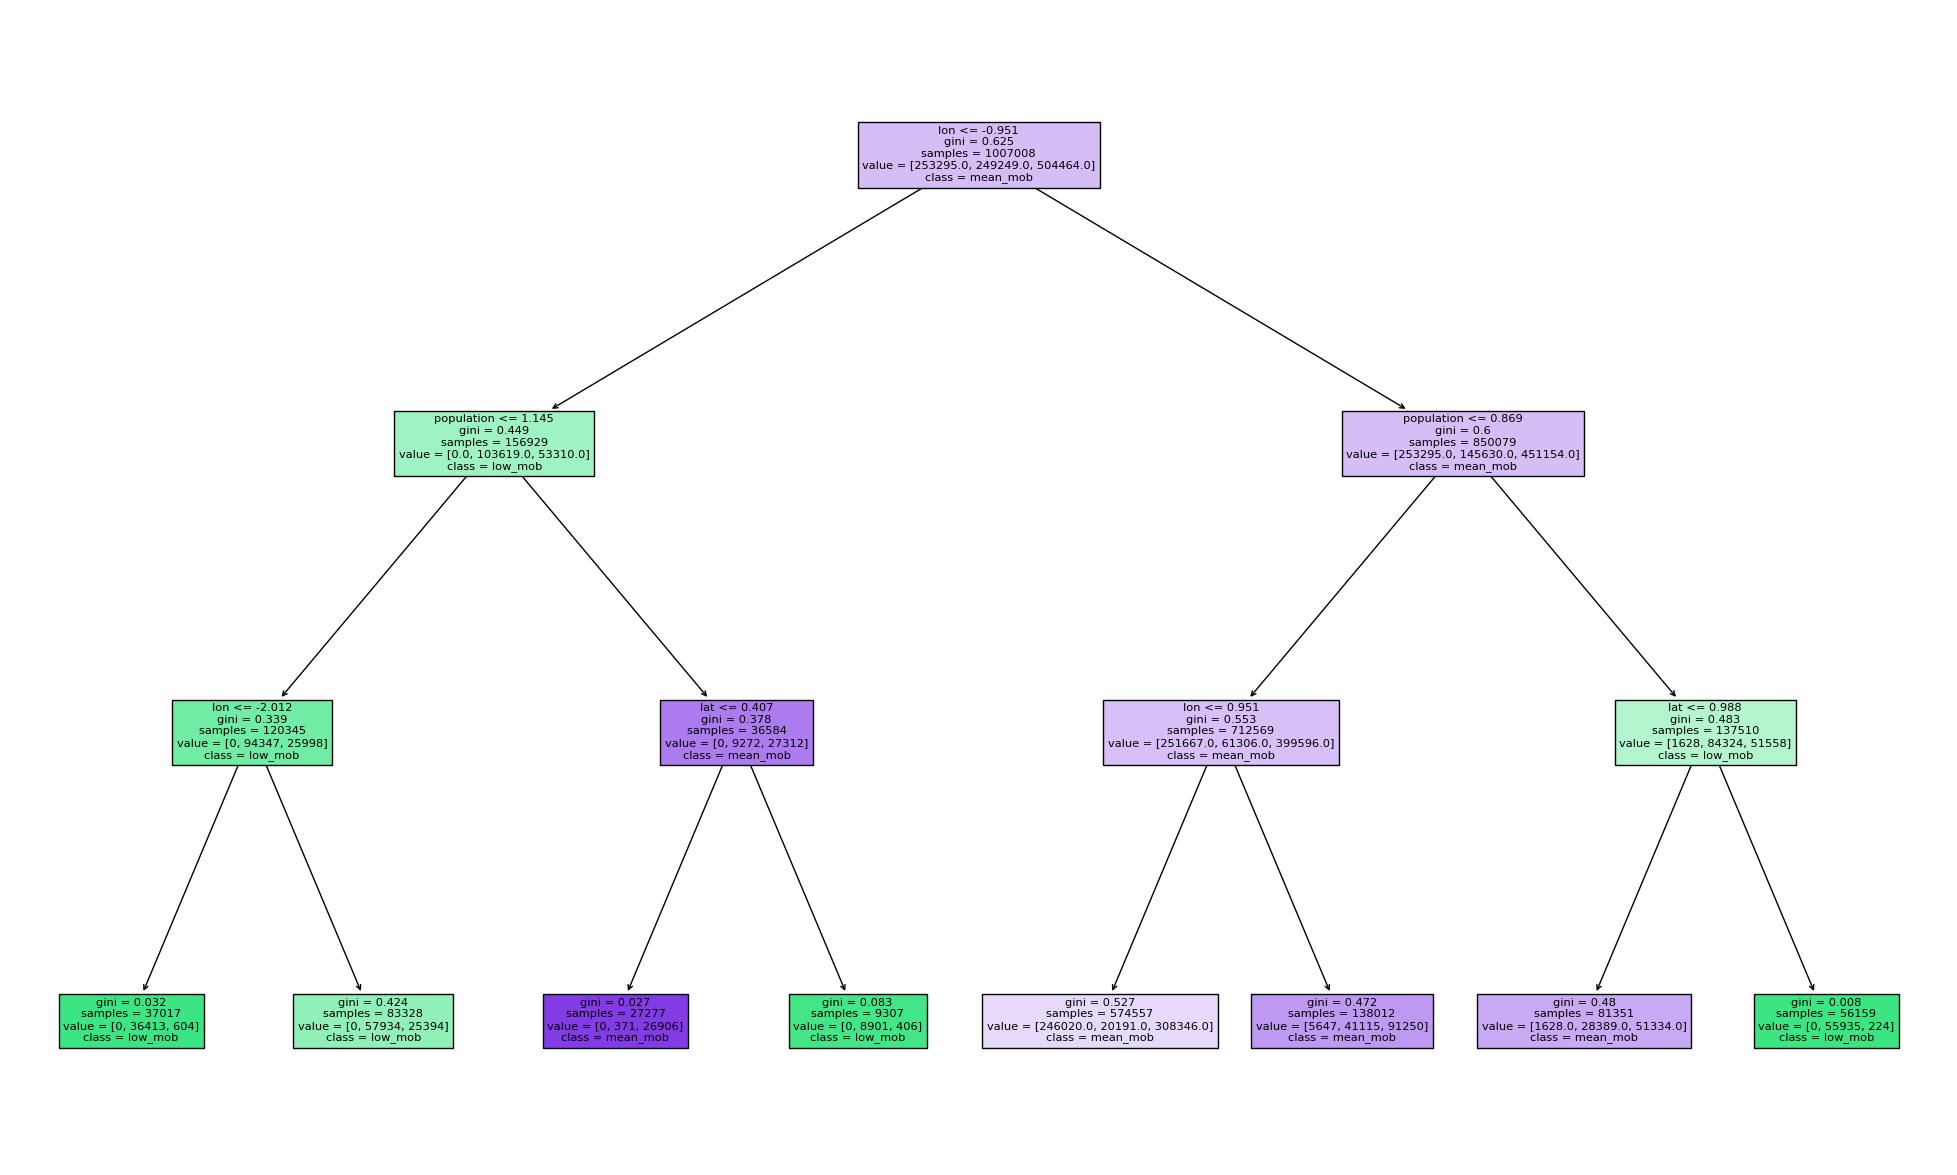

In [67]:
from sklearn.tree import plot_tree

X_train, X_test, y_train, y_test = model_selection(X,lfb_target["Label_mean_mob"])

la = LabelEncoder()
la.fit_transform(y_train)
la.transform(y_test)

model = DecisionTreeClassifier(max_depth=3)
model.fit(X_train, y_train)

# Afficher l'arbre de décision
plt.figure(figsize=(25, 15))
plot_tree(model,feature_names=X_train.columns, class_names=model.classes_, filled=True)
plt.show()

##### <span style="color: #d7dbdd  ; margin-left: 40px;">**6.3. XGBoostRegressor**</span>

In [91]:
from xgboost import XGBRegressor
import xgboost as xgb

In [ ]:
# Prend du temps active la cellule en dessous car il y a les meilleurs paramètres 

param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_depth': [3, 5, 7],            # Maximum depth of each tree
    'learning_rate': [0.01, 0.1, 0.3], # Learning rate
}
X_train, X_test, y_train, y_test = model_selection(X,lfb_target["mean_per_station"])

grid_xgb = GridSearchCV(estimator=XGBRegressor(), param_grid=param_grid)

grid_xgb.fit(X_train, y_train)
print("Score: ",grid_xgb.score(X_test, y_test), "Best params: ",grid_xgb.best_params_)

In [90]:
X_train, X_test, y_train, y_test = model_selection(X,lfb_target["mean_per_station"])

model_xgb = XGBRegressor(eta= 0.3, max_depth= 7, n_estimators=300)
model_xgb.fit(X_train, y_train)
print("score train = ", model_xgb.score(X_train, y_train))
print("score test = ", model_xgb.score(X_test, y_test))
y_pred_xgb = model_xgb.predict(X_test)

score train =  0.9940048935583862
score test =  0.9922281209749044


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

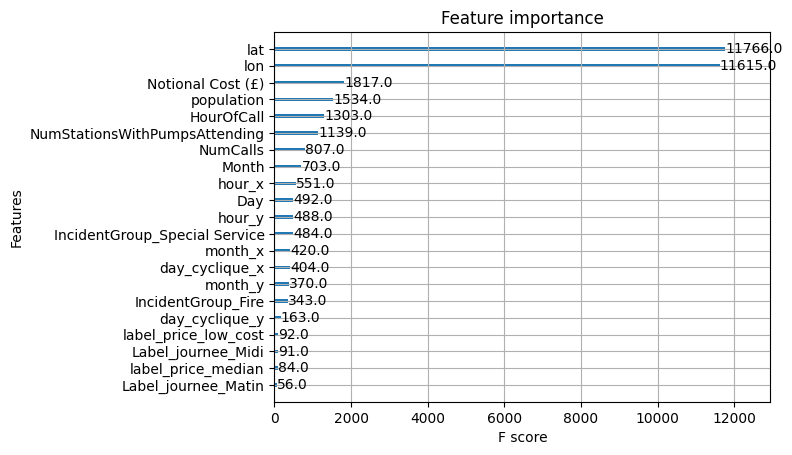

In [94]:
xgb.plot_importance(model_xgb)

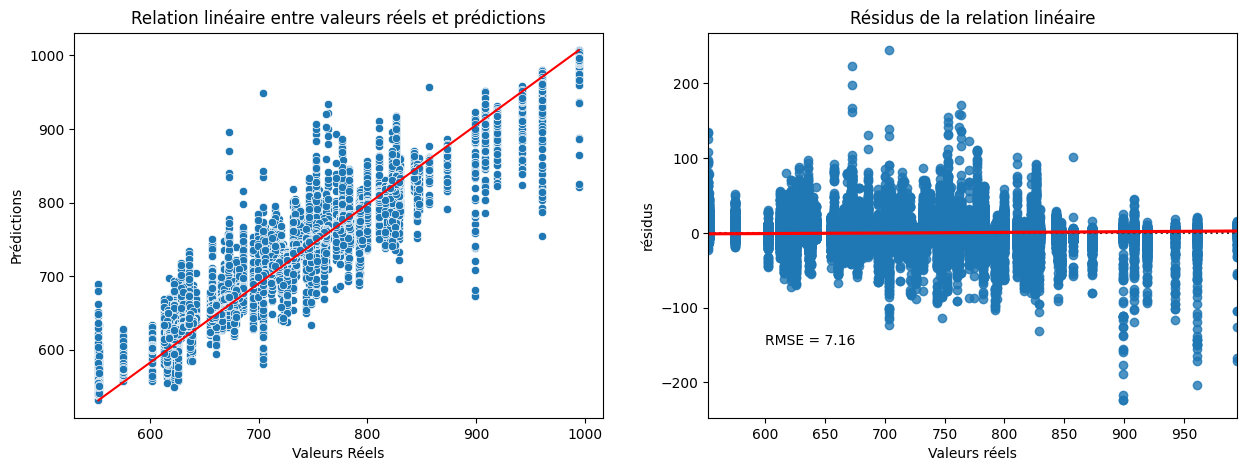

In [95]:
rmse_xbg = np.round(np.sqrt(mean_squared_error(y_test, y_pred_xgb)), 2)

plt.figure(figsize=(15,5))

plt.subplot(121)
sns.scatterplot(x= y_test, y= y_pred_xgb)
plt.plot([y_test.min(), y_test.max()], [y_pred_xgb.min(), y_pred_xgb.max()], "r")
plt.xlabel('Valeurs Réels')
plt.ylabel("Prédictions")
plt.title("Relation linéaire entre valeurs réels et prédictions")

plt.subplot(122)
sns.residplot(x= y_test, y= y_pred_xgb, line_kws=dict(color= "r"), lowess=True)
plt.annotate(f'RMSE = {rmse_xbg}', (600,-150))
plt.xlabel('Valeurs réels')
plt.ylabel('résidus')
plt.title('Résidus de la relation linéaire')
plt.show()

##### <span style="color: #d7dbdd  ; margin-left: 40px;">**6.4. XGBoostClassifier**</span>

In [36]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

In [111]:
X_train, X_test, y_train, y_test = model_selection(X,lfb_target["Label_mean_mob"])
la = LabelEncoder()
y_train = la.fit_transform(y_train)
y_test = la.transform(y_test)

xgb_clf = XGBClassifier()
xgb_clf.fit(X_train, y_train)
xgb_clf.score(X_test, y_test)

0.9915273761479552

In [113]:
la.inverse_transform(np.unique(y_pred_xgb_clf))

array(['fast_mob', 'low_mob', 'mean_mob'], dtype=object)

In [118]:
y_pred_xgb_clf = xgb_clf.predict(X_test)
name = {0: 'fast', 1: "low", 2: 'mean'}
matrice = pd.crosstab(y_test, y_pred_xgb_clf, rownames=['True'], colnames=['Predict'])
matrice = matrice.rename(columns=name, index=name)
display(matrice)
print(classification_report(y_test, y_pred_xgb_clf))

Predict   fast    low    mean
True                         
fast     63100      2     458
low          4  61797     589
mean       614    466  124722

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     63560
           1       0.99      0.99      0.99     62390
           2       0.99      0.99      0.99    125802

    accuracy                           0.99    251752
   macro avg       0.99      0.99      0.99    251752
weighted avg       0.99      0.99      0.99    251752



## <span style="color: #2980b9  ">**6. Machine Learning Exam for Streamlit** </span>

In [23]:
import streamlit as st
import pickle

### <span style="color: #34495e ; margin-left: 40px;">**6.1. DecisionTreeRegressor**</span>

In [18]:
features = lfb[["Longitude", "Latitude", "lon", "lat", "population", "Distance"]]
target = lfb["mean_per_station"]

In [22]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2)

In [24]:
clf_regressor = DecisionTreeRegressor()

clf_regressor.fit(X_train, y_train)
with open('Streamlit_DecisionReg.pkl', 'wb') as tree_reg:
    pickle.dump(clf_regressor, tree_reg)

print(clf_regressor.score(X_train, y_train))

print(clf_regressor.score(X_test, y_test))

y_pred_reg_tree = clf_regressor.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred_reg_tree))
print(rmse)

1.0
0.9999998748105995
0.028779333276380322


### <span style="color: #34495e ; margin-left: 40px;">**6.2. DecisionTreeClassifier**</span>

In [27]:
X = lfb[["Longitude", "Latitude", "lon", "lat", "population", "Distance"]]
y = lfb['Label_mean_mob']

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

In [29]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

In [30]:
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
with open('Classification_Stream.pkl', 'wb') as tree_clf:
    pickle.dump(clf, tree_clf)

clf.score(X_test, y_test)

0.9999801391845944

In [31]:
y_pred = clf.predict(X_test)

In [33]:
matrice = pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Prediction'])
matrice = matrice.rename(columns={0: "fast_time", 1: "low_time", 2:'mean_time'}, index={0: "fast_time", 1: "low_time", 2:'mean_time'})
matrice

Prediction  fast_time  low_time  mean_time
True                                      
fast_time       63319         0          3
low_time            0     62371          0
mean_time           1         1     126057

<Axes: xlabel='Prediction', ylabel='True'>

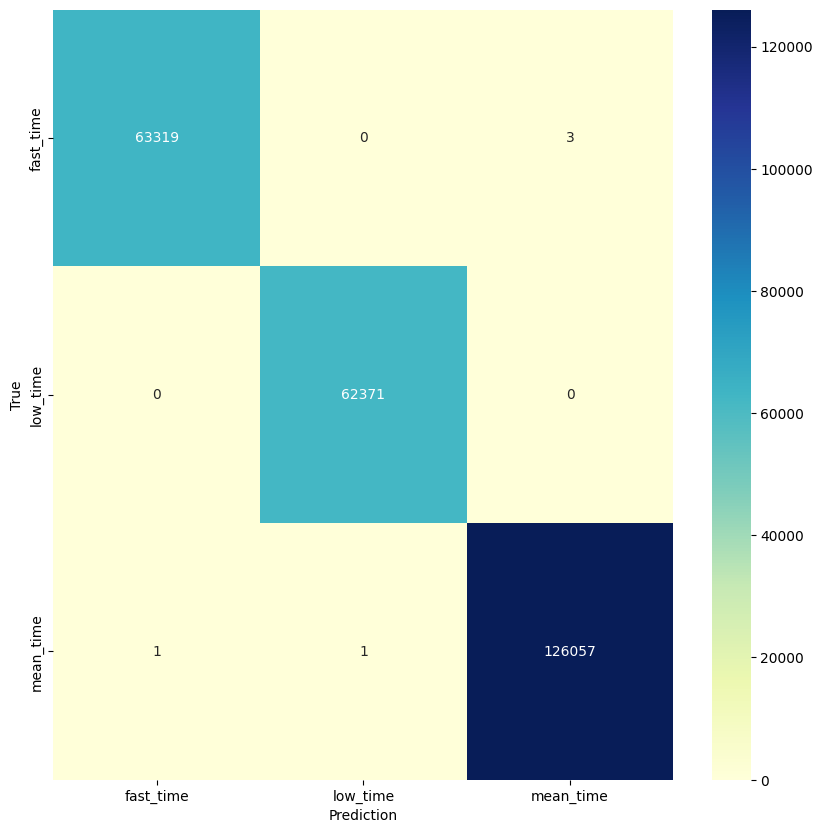

In [34]:
plt.figure(figsize=(10,10))
sns.heatmap(matrice, annot=True, cmap="YlGnBu", fmt='.0f')

In [37]:
report = classification_report(y_test, y_pred, output_dict=True)

# Convertir le rapport en DataFrame pandas
df_report = pd.DataFrame(report).transpose()
df_report = df_report.rename(index={"0": "fast_time", "1": "low_time", "2":'mean_time'})
df_report.to_csv('report.csv')


In [38]:
df_report

precision    recall  f1-score       support
fast_time      0.999984  0.999953  0.999968   63322.00000
low_time       0.999984  1.000000  0.999992   62371.00000
mean_time      0.999976  0.999984  0.999980  126059.00000
accuracy       0.999980  0.999980  0.999980       0.99998
macro avg      0.999981  0.999979  0.999980  251752.00000
weighted avg   0.999980  0.999980  0.999980  251752.00000